# Proyecto de ciencia de datos - MINE 4101

## Expectativas stakeholder:
"El objetivo de esta entrega es dar inicio a la creación del tablero en Power BI, que permitirá integrar y visualizar toda la información disponible. La idea es que este tablero se convierta en una herramienta dinámica, que pueda ser alimentada continuamente en el futuro con nuevos datos que vayamos recopilando."

#### Comentarios adicionales:
"Podemos revisar pacientes con complicaciones, infecciones, sobrevida, y revisar grupos etarios.


## Insumos entregados a corte 25 de septiembre de 2025

* Cirugias_Hepaticas_consolidado.xlsx   (Higado)
* Cirugias_Pancreaticas_Consolidado.xlsx (Pancreas)
* Colecistectomias_Laparoscopicas_consolidado.xlsx  (Vesicula biliar) "extracción de la vesícula biliar mediante laparoscopia" "técnica mínimamente invasiva (no se abre el abdomen por completo, sino que se usan pequeñas incisiones y una cámara)." -- suelen ser mas comunes, 
* Otras_cirugias_consolidado.xlsx 
* Trasplante_hepático_consolidado.xlsx



## 0. Importación de librerías y preparación del entorno de trabajo

In [538]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [539]:
path = os.path.join(
    "C:\\",
    "Users",
    "jmriv",
    "OneDrive - Universidad de los andes",
    "Semestres uniandes",
    "2025-2",
    "Ciencia de datos aplicada",
    "Proyecto transplantes hepáticos Fundación Sanatfé",
    "Trasplante hepático consolidado.xlsx"
)

## Etapa 1: Entendimiento de los datos

In [540]:
df_original = pd.read_excel(path,index_col=0)
df_original.sample(3)

,Año_Tx,Mes_Tx#1,Fecha_Tx,Edad_Al_Tx,Sexo_Receptor,Código de anonimización,Fecha_nacimiento,EPS,Grupo_Sanguíneo_Receptor,RH_Receptor,...,POSTMORAL_Categoría,RETREAT_Valor,COMBOMORAL_Valor,COMBOMORAL_Categoría,αFP_1m_PostTx,αFP_6m_PostTx,αFP_1año_PostTx,Recurrencia_ HCC,Fecha_Recurrencia,Lugar_De_Recurrencia
#_Paciente,,,,,,,,,,,,,,,,,,,,,
333,2013,11,2013-11-13,59.909589,1,TXHEP333,1953-12-31 00:00:00,25.0,AB,(+),...,9999.0,9999.0,9999.0,9999.0,9999,9999,9999,9999.0,9999,9999.0
624,2022,3,2022-03-16,67.676712,1,TXHEP624,1954-07-29 00:00:00,2.0,O,(+),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502,2017,9,2017-09-03,63.915068,1,TXHEP502,1953-10-20 00:00:00,2.0,A,(+),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2019-03-01 00:00:00,NaN


In [541]:
print(f'La base de datos tiene {df_original.shape[1]} columnas y {df_original.shape[0]} filas.')

La base de datos tiene 284 columnas y 736 filas.


A partir del diccionario y al revisar el comportamiento del dataframe, podemos concluir que los valores de 9999 corresponden a datos nulos.

Por esto, <span style="color:red">se remplazaran como valores perdidos con el fin de tener un cálculo mas preciso de completitud de la información </span>

In [542]:
valores_nulos=[9999, 9999.0, '9999',999,99999,'8888.0',8888.0 ]

In [543]:
df = df_original.replace(
    valores_nulos,
    np.nan)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\753223659.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df_original.replace(


Adicionalmente, se eliminarán espacios vacíos al inicio y final de los nombres de las columnas

In [544]:
df.columns = df.columns.str.strip()

Se validará el número de datos nulos presentes en las columnas

In [545]:
null_count = df.isnull().sum()
null_count[null_count==0]

Año_Tx                                0
Mes_Tx#1                              0
Fecha_Tx                              0
Edad_Al_Tx                            0
Sexo_Receptor                         0
Código de anonimización               0
Año_Tx2 (si no retx, poner año tx)    0
Año_Tx#3                              0
dtype: int64

In [546]:
# Miraremos cuántas filas tienen más del 95% de datos nulos
null_count[null_count>700].shape

(59,)

De las 286 variables vemos que solo 8 tienen todos los datos, y 59 tienen más del 95% de los datos como valores nulos.

### Selección de variables de interés

Dado el elevado número de variables y la poca completitud de las mismas se decidió trabajar con un subconjunto de las variables.

Para esto, se usaron los siguientes criterios de selección:
- **Completitud de los datos**: el número de valores no nulos
- **Variabilidad de los datos**: el número de veces que se repite un dato en una columna. La idea es evitar las columnas donde la muestra puede estar desbalanceada
- **Concepto del experto**: el experto indicó que variables considera que se deben priorizar en el análisis

Adicionalmente, se dividieron las variables en las siguientes categorías:
- **Identificación del paciente**
- **Transplante y cirugía**
- **Hepatocarcinoma y cáncer**
- **Scores clínicos**
- **Comorbilidades y antecedentes**
- **Evaluaciones diagnósticas**
- **Seguimiento y sobrevida**
- **Postoperatorio y complicaciones**
- **Otras**

De este proceso se seleccionaron 108 variables


In [547]:
selected_columns = [
    "Año_Tx",
    "Mes_Tx#1",
    "Edad_Al_Tx",
    "Tiempo_En_Lista_Días",
    "Tiempo_En_Lista_Meses",
    "Tiempo_En_Lista_Años",
    "Sexo_Receptor",
    "EPS",
    "Causa_1_Tx_Hepático_",
    "Causa_2_Tx_Hepático_",
    "Hepatocarcinoma",
    "Child_Pugh_Letra",
    "MELD_Score",
    "Causa_Tx_Renal",
    "Peso_Pre_Tx",
    "BMI",
    "Composición_Corporal",
    "Falla_Cardiaca_Pre_Tx",
    "Antecedente_De_Tabaquismo",
    "Antecedente_De_Alcoholismo",
    "Enfermedad_Coronaria_Pre_Tx",
    "Infarto_Cardiaco_Pre_Tx",
    "Diabetes_Mellitus_Pre_Tx",
    "Hipertensión_Arterial_Pre_Tx",
    "Colesterol_TotalPre_Tx",
    "LDL_Pre_Tx",
    "HDL_Pre_Tx",
    "Triglicéridos_Pre_Tx",
    "Dislipidemia_Pre_Tx",
    "MDRD_Categórico_PreTx",
    "CMV_Receptor",
    "EKG_PreQx",
    "EKG_PreQx_Valor",
    "Valvulopatía_Pre_Tx",
    "Ecocardiograma_PreQx_FE%",
    "Ecocardiograma_PreQx-FE_Cod",
    "Ecocardiograma_PreQx_RC%",
    "Ecocardiograma_PreQx_RC",
    "Ecocardiograma_PreQx_Hipertensión_Pulmonar",
    "Ecocardiograma_PreQx_TAPSE",
    "Ecocardiograma_PreQx_TASVE",
    "Ecocardiograma_PreQx_Disfunción_Diastólica",
    "METS",
    "Tx#1",
    "Edad_Donante_Tx#1",
    "Sexo_Donante_Tx#1",
    "Causa_Muerte_Donante_Tx#1",
    "Tipo_de_Cx-Trasplante_Tx#1",
    "Trasplante_Combinado-Hígado-Riñón_Tx#1",
    "#_Unidades_Glóbulos_Rojos_Tx#1",
    "#_Unidades_Plasma_Fresco_Congelado_Tx#1",
    "#_Unidades_Crioprecipitados_Tx#1",
    "#_Unidades_Plaquetas_Tx#1",
    "Tiempo_Quirúrgico_Tx#1",
    "Antibiótico_Profiláctico_VS_Terapéutico",
    "Días_Tratamiento_Antibiótico_Previo_A_Tx#1",
    "Tiempo_De_Dosis_Hasta_Tx#1",
    "Tiempo_Sonda_Vesical",
    "Tiempo_CVC",
    "Soporte_Vasopresor_PeriTx",
    "Levosimendan_PeriTx",
    "Noradrenalina_PeriTx",
    "Adrenalina_PeriTx",
    "Vasopresina_PeriTx",
    "Dopamina_PeriTx",
    "Amiodarona_PeriTx",
    "Stent",
    "Requirió_Reconstrucción_Biliar",
    "Profilaxis_Antitrombótica",
    "Días_de_Profilaxis_Antitrombótica",
    "Fast_Track",
    "Días_En_UCI",
    "Días_En_Hospitalización_Piso",
    "Días_Totales_Intrahospitalarios",
    "Fecha_Egreso_UCI",
    "Fecha_Egreso_Hospitalario",
    "¿Complicación?",
    "#_De_Complicaciones",
    "Tipo_De_Complicación_1",
    "Rechazo_Agudo",
    "Severidad_Rechazo_Agudo",
    "Rechazo_Crónico",
    "Infección_POP",
    "Tipo_Infección_1",
    "Germen_1",
    "Tiempo_Desde_Tx_Infección_1",
    "Falla_Cardiaca_POP",
    "Arritmia_POP",
    "Infarto_POP",
    "EKG_VALOR_POP",
    "Ecocardiograma_POP_FE%",
    "Ecocardiograma_POP_PASP",
    "Ecocardiograma_POP_Otros",
    "Retrasplante",
    "Indicación_Retrasplante",
    "Año_Tx2 (si no retx, poner año tx)",
    "Re_Re trasplante",
    "Indicación_Re_Re_trasplante",
    "PTLD",
    "Neoplasia_PostTx",
    "Grado_HCC",
    "Estadio",
    "Sobrevida_PeriQx_30_días_POP",
    "Vivo_Hoy",
    "Fecha_Control/Muerte",
    "Sobrevida_Días",
    "Sobrevida_Meses",
    "Sobrevida_Años",
    "Causa_De_Muerte",
    "Complicación_Asociada",
    "Fecha-Enlistamiento",
    "αFP_PreTx",
    "αFP_Al_Dx",
    "Tiempo_Isquemia_Fría_Tx#1",
    "Días_Sobrevida_Injerto_#1",
    "Meses_Sobrevida_Injerto_#1",
    "Años_Sobrevida_Injerto_#1",
    "Diámetro_Nódulo_Principal_(cm)_Al_Dx",
    "Ki67",
    "#_Nódulos_Al_Dx"
]

In [548]:
categorias = {
    'Identificación del paciente': ['#_Paciente',	'Edad_Al_Tx',	'Sexo_Receptor',
    'Código de anonimización ',	'Fecha_nacimiento',	'EPS',	'Grupo_Sanguíneo_Receptor',	'RH_Receptor',	
    'COD_Grupo_Sanguíneo_Receptor',	'COD_RH_Receptor',	'Fecha-Enlistamiento',
    'Tiempo_En_Lista_Días',	'Tiempo_En_Lista_Meses',	'Tiempo_En_Lista_Años',	
    'BMI',	'Composición_Corporal',	'Enfermedad_Coronaria_Pre_Tx',	
    'Edad_Donante_Tx#1',	'Sexo_Donante_Tx#1',	'Edad_Donante_Tx#2',
    'Sexo_Donante_Tx#2',	'Edad_Donante_Tx#3',	'Sexo_Donante_Tx#3'
    ],

    'Trasplante y cirugía': ['Año_Tx',	'Mes_Tx#1',	'Fecha_Tx',	'Causa_1_Tx_Hepático_',
    'Causa_2_Tx_Hepático_',	'Causa_Tx_Renal',	'Peso_Pre_Tx',	'Falla_Cardiaca_Pre_Tx',	
    'Infarto_Cardiaco_Pre_Tx',	'Diabetes_Mellitus_Pre_Tx',	'Hipertensión_Arterial_Pre_Tx',	
    'Colesterol_TotalPre_Tx',	'LDL_Pre_Tx',	'HDL_Pre_Tx',	'Triglicéridos_Pre_Tx',	
    'Dislipidemia_Pre_Tx',	'MDRD_Score_Pre_Tx',	'MDRD_Categórico_PreTx',	
    'Valvulopatía_Pre_Tx',	'Tx#1',	'Causa_Muerte_Donante_Tx#1',	'CMV_Donante_Tx#1',
    'Cirujano_Rescate_1_Tx#1',	'Cirujano_Rescate_2_Tx#1',	'Tipo_de_Cx-Trasplante_Tx#1',	
    'Trasplante_Combinado-Hígado-Riñón_Tx#1',	'Tiempo_Isquemia_Fría_Tx#1',	
    'Tiempo_Isquemia_Caliente_Tx#1',	'Arterialización_Portal',	'Injerto_Aórtico_Tx#1',	
    '#_Unidades_Glóbulos_Rojos_Tx#1',	'#_Unidades_Plasma_Fresco_Congelado_Tx#1',	
    '#_Unidades_Crioprecipitados_Tx#1',	'#_Unidades_Plaquetas_Tx#1',	
    'Tiempo_Quirúrgico_Tx#1',	'Antibiótico_Profiláctico_VS_Terapéutico',	
    'Días_Tratamiento_Antibiótico_Previo_A_Tx#1',	'Antibiótico_1__Tx#1',	'Antibiótico_2_Tx#1',	
    'Antibiótico_3_Tx#1',	'Antifúngico_Tx#1',	'Tiempo_De_Dosis_Hasta_Tx#1',	'Cirujano_Principal_Tx#1',	
    'Cirujano_Ayudante_Tx#1',	'Fecha_Colocación_Sonda_Vesical',	'Fecha_Colocación_CVC',	
    'Soporte_Vasopresor_PeriTx',	'Levosimendan_PeriTx ',	'Levosimendam_Dosis',	
    'Noradrenalina_PeriTx',	'Noradrenalina_Dosis',	'Adrenalina_PeriTx',	
    'Vasopresina_PeriTx',	'Vasopresina_Dosis',	'Dopamina_PeriTx',	'Dopamina_Dosis',	
    'Amiodarona_PeriTx',	'Amiodarona_Dosis',	'Tx_Soporte_Inotrópico',	
    'Retrasplante',	'Indicación_Retrasplante',	'Fecha-Enlistamiento_Tx#2',	
    'Año_Tx2 (si no retx, poner año tx)',	'Fecha_Tx#2',	'Mes_Tx#2',	'Días_Reenlistado_Tx#2',	
    'Días_Desde_Tx#1',	'Causa_Muerte_Donante_Tx#2',	'CMV_Donante_Tx#0',	'Cirujano_Rescate_1_Tx#2',	
    'Cirujano_Rescate_2_Tx#2',	'Tipo_de_Cx-Trasplante_Tx#2',	'Tiempo_Isquemia_Fría_Tx#2',	'Tiempo_Isquemia_Caliente_Tx#2',	
    'Injerto_Aórtico_Tx#2',	'#_Unidades_Glóbulos_Rojos_Tx#2',	'#_Unidades_Plasma_Fresco_Congelado_Tx#2',	
    '#_Unidades_Crioprecipitados_Tx#2',	'#_Unidades_Plaquetas_Tx#2',	'Tiempo_Quirúrgico_Tx#2',	
    'Días_Tratamiento_Antibiótico_Previo_A_Tx#2',	'Antibiótico_1_Tx#2',	'Antibiótico_2_Tx#2',	
    'Antibiótico_3_Tx#2',	'Antifúngico_Tx#2',	'Segunda_Dosis_Tx#2',	'Tiempo_De_Dosis_Hasta_Tx#2',	
    'Cirujano_Principal_Tx#2',	'Cirujano_Ayudante_Tx#2',	'Re_Re trasplante',	'Indicación_Re_Re_trasplante',	
    'Fecha-Enlistamiento_Tx#3',	'Año_Tx#3',	'Fecha_Tx#3',	'Mes_Tx#3',	'Días_Reenlistado_Tx#3',	'Días_Desde_Tx#1',	'Causa_Muerte_Donante_Tx#3',	
    'CMV_Donante_Tx#3',	'Cirujano_Rescate_1_Tx#3',	'Cirujano_Rescate_2_Tx#3',	'Tipo_de_Cx-Trasplante_Tx#3',	'Tiempo_Isquemia_Fría_Tx#3',	'Tiempo_Isquemia_Caliente_Tx#3',	
    'Injerto_Aórtico_Tx#3',	'#_Unidades_Glóbulos_Rojos_Tx#3',	'#_Unidades_Plasma_Fresco_Congelado_Tx#3',	'#_Unidades_Crioprecipitados_Tx#3',	'#_Unidades_Plaquetas_Tx#3',	
    'Tiempo_Quirúrgico_Tx#3',	'Cirujano_Principal_Tx#3',	'Cirujano_Ayudante_Tx#3',	'Años_Desde_El_Tx',	'Fecha_Tx_A_PTLD',	'Tiempo_Tx_A_PTLD',	'Neoplasia_PostTx',	'Fecha_Neoplasia_PostTx',	
    'Tiempo_Tx_A_Neoplasia_PostTx',	'Fecha_última_Terapia_Local_PreTx',	'αFP_PreTx',	'Ca-19-9_PreTx',	'Neutrófilos_PreTx',	'Plaquetas_PreTx',	'Linfocitos_PreTx',	'αFP_1m_PostTx',	
    'αFP_6m_PostTx',	'αFP_1año_PostTx'
    ],

    'Hepatocarcinoma y cáncer': ['Hepatocarcinoma',	'Hepatocarcinoma',	'αFP_Al_Dx',	'#_Nódulos_Al_Dx',	'Diámetro_Nódulo_Principal_(cm)_Al_Dx',	
    'Sumatoria_#Nódulos_y_Diámetros_Al_Dx',	'Cumple_Milán',	'Cumple_UCSF',	'Cumple_Up_To_Seven',	'Terapia_Local_1',	'Terapia_Local_2',	'#_Sesiones',	'Patrón_Histológico',
    'Grado_HCC',	'Invasión_Vascular',	'Trombosis_Porta_Tumoral',	'Invasión_Linfática',	'Invasión_Nerviosa',	'Necrosis_Tumoral',	'#Nódulos_Viables',	'Diámetro_Tumor_Viable_Más_Grande_Patología',
    'Sumatoria_Nódulos_Viables_y_Diámetro_Tumor_Más_Grande_Patología',	'Ki67',	'Mitosis',	'p53',	'αFP_Patología',	'T',	'N',	'M',	'Estadio',

    ],

    'Scores clínicos': ['Child_Pugh_Letra',	'MELD_Score',	'PREMORAL_Valor',	'PREMORAL_Categoría',	'POSTMORAL_Valor',	'POSTMORAL_Categoría',	'RETREAT_Valor',	'COMBOMORAL_Valor',	'COMBOMORAL_Categoría'
    ],

    'Comorbilidades y antecedentes': ['Antecedente_De_Tabaquismo',	'Antecedente_De_Alcoholismo',	'Ecocardiograma_PreQx_Hipertensión_Pulmonar',	'Andrenalina_Dois',	'Falla_Cardiaca_POP'
    ],

    'Evaluaciones diagnósticas': ['CMV_Receptor',	'EKG_PreQx',	'EKG_PreQx_Valor',	'Ecocardiograma_PreQx_FE%',	'Ecocardiograma_PreQx-FE_Cod',	'Ecocardiograma_PreQx_RC%',	'Ecocardiograma_PreQx_RC',	
    'Ecocardiograma_PreQxPSAP',	'Ecocardiograma_PreQx_TAPSE ',	'Ecocardiograma_PreQx_TASVE',	'Ecocardiograma_PreQx_Disfunción_Diastólica',	'METS',	'EKG_VALOR_POP',	'Ecocardiograma_POP_FE%',	
    'Ecocardiograma_POP_PASP',	'Ecocardiograma_POP_Otros',	'NLR',	'PLR'
    ],

    'Seguimiento y sobrevida': [
       'Fecha_Retiro_Sonda_Vesical',	'Tiempo_Sonda_Vesical',	'Fecha_Retiro_CVC',	'Tiempo_CVC',	'Días_de_Profilaxis_Antitrombótica',	'Días_En_Hospitalización_Piso',	'Días_Totales_Intrahospitalarios',	'Vivo_Hoy',	'Fecha_Control/Muerte',	'Sobrevida_Días',	'Sobrevida_Meses',	'Sobrevida_Años',	'Último_Análisis_De_Mortalidad',	'Causa_De_Muerte',	'Sobrevida_Injerto_#1',	'Control_Injerto_#1',	'Días_Sobrevida_Injerto_#1',	'Meses_Sobrevida_Injerto_#1',	'Años_Sobrevida_Injerto_#1',	'Sobrevida_Injerto_#2',	'Control_Injerto_#2',	'Días_Sobrevida_Injerto_#2',	'Meses_Sobrevida_Injerto_#2',	'Años_Sobrevida_Injerto_#2',	'Sobrevida_Injerto_#3',	'Control_Injerto_#3',	'Días_Sobrevida_Injerto_#3',	'Meses_Sobrevida_Injerto_#3',	'Años_Sobrevida_Injerto_#3',	'PTLD',	'Recurrencia_ HCC',	'Fecha_Recurrencia',	'Lugar_De_Recurrencia',

    ],

    'Postoperatorio y complicaciones': ['Bilirrubina_Total_POP',	'COD_ Bilirrubina_Total_POP',	'Bilirrubina_Directa_POP',	'COD_Bilirrubina_Directa',	'¿Complicación?',	'#_De_Complicaciones',	'Tipo_De_Complicación_1',
    'Inmunosupresor_1',	'Inmunosupresor_2',	'Inmunosupresión_con_Anticuerpos',	'Rechazo_Agudo',	'Severidad_Rechazo_Agudo',	'Rechazo_Crónico',	'Infección_POP',	'Tipo_Infección_1',	'Germen_1',	'Fecha_Infección_1',
    'Tiempo_Desde_Tx_Infección_1',	'Tipo_Infección_2',	'Germen_2',	'Fecha_Infección_2',	'Tiempo_Desde_Tx_Infección_2',	'Tipo_Infección_3',	'Germen_3',	'Fecha_Infección_3',	'Tiempo_Desde_Tx_Infección_3',	'Stent',
    'Requirió_Reconstrucción_Biliar',	'Fecha_Reconstrucción_Biliar',	'Tiempo_Reconstrucción_Biliar',	'Profilaxis_Antitrombótica',	'Medicamento_Antitrombótica',	'Arritmia_POP',	'Infarto_POP',	'Fast_Track',	
    'Días_En_UCI',	'Fecha_Egreso_UCI ',	'Fecha_Egreso_Hospitalario',	'Sobrevida_PeriQx_30_días_POP',	'Complicación_Asociada'
    ]
}

In [549]:
def clasificar_variable(var):
    for categoria, palabras in categorias.items():
        if var in palabras:
            return categoria
    return 'Otras / No clasificadas'

df_vars = pd.DataFrame({'Variable': selected_columns})

df_vars['Categoría'] = df_vars['Variable'].apply(clasificar_variable)

# Vista general
df_vars.groupby('Categoría').size().sort_values(ascending=False)

Categoría
Trasplante y cirugía               43
Postoperatorio y complicaciones    20
Seguimiento y sobrevida            15
Evaluaciones diagnósticas          14
Identificación del paciente        12
Hepatocarcinoma y cáncer            7
Comorbilidades y antecedentes       4
Otras / No clasificadas             3
Scores clínicos                     2
dtype: int64

## Etapa 2: Limpieza y enriquecimiento del dataset

Se revisará la calidad de cada variable seleccionada. En caso de ser necesario se ajustará

In [550]:
def ver_datos(data, col_name, categorica=False):
    print(data[col_name].describe())
    print('--'*10)
    print(f'Número de datos nulos: {data[col_name].isnull().sum()}')
    if categorica:
        print('--'*10)
        print(data[col_name].value_counts(dropna=False))

In [551]:
def limpiar_numericas(data, col_name):
    temp = (
    data[col_name]
    .astype(str)
    .str.replace(',', '.', regex=False)
    )
    data[col_name] = pd.to_numeric(temp, errors='coerce')

In [552]:
def parse_date(date, valores_nulos=[]):
    if pd.isna(date) or date in valores_nulos:
        return pd.NaT
    try:
        if isinstance(date, int):
            return pd.to_datetime(date, origin="1899-12-30", unit="D", errors='coerce')
        else:
            return pd.to_datetime(date, dayfirst=True, errors='coerce')
    except:
        return pd.NaT

### Año_Tx

In [553]:
ver_datos(df, 'Año_Tx')

count     736.000000
mean     2013.747283
std         6.839958
min      1988.000000
25%      2009.000000
50%      2014.000000
75%      2019.000000
max      2025.000000
Name: Año_Tx, dtype: float64
--------------------
Número de datos nulos: 0


### Mes_Tx#1

In [554]:
ver_datos(df, 'Mes_Tx#1')

count    736.000000
mean       6.474185
std        3.482026
min        1.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       12.000000
Name: Mes_Tx#1, dtype: float64
--------------------
Número de datos nulos: 0


### Edad_Al_Tx

In [555]:
ver_datos(df, 'Edad_Al_Tx')

count    736.000000
mean      53.880852
std       15.650689
min        0.000000
25%       48.063699
50%       58.452055
75%       64.626712
max       84.813699
Name: Edad_Al_Tx, dtype: float64
--------------------
Número de datos nulos: 0


### Tiempo en lista (Tiempo_En_Lista_Días, Tiempo_En_Lista_Meses, Tiempo_En_Lista_Años)

In [556]:
ver_datos(df, 'Tiempo_En_Lista_Días')

count      705.000000
mean       539.451064
std       4177.666859
min          0.000000
25%         19.000000
50%         57.000000
75%        168.000000
max      45745.000000
Name: Tiempo_En_Lista_Días, dtype: float64
--------------------
Número de datos nulos: 31


In [557]:
ver_datos(df, 'Tiempo_En_Lista_Meses')

count     705.000000
mean       17.981702
std       139.255562
min         0.000000
25%         0.633333
50%         1.900000
75%         5.600000
max      1524.833333
Name: Tiempo_En_Lista_Meses, dtype: float64
--------------------
Número de datos nulos: 31


In [558]:
ver_datos(df, 'Tiempo_En_Lista_Años')

count    705.000000
mean       1.498475
std       11.604630
min        0.000000
25%        0.052778
50%        0.158333
75%        0.466667
max      127.069444
Name: Tiempo_En_Lista_Años, dtype: float64
--------------------
Número de datos nulos: 31


### Sexo_Receptor

In [559]:
ver_datos(df, 'Sexo_Receptor', True)

count    736.000000
mean       1.491848
std        0.500274
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: Sexo_Receptor, dtype: float64
--------------------
Número de datos nulos: 0
--------------------
Sexo_Receptor
1    374
2    362
Name: count, dtype: int64


### EPS

In [560]:
ver_datos(df, 'EPS', True)

count    702.000000
mean       6.888889
std        8.592646
min        0.000000
25%        2.000000
50%        2.000000
75%       10.000000
max       37.000000
Name: EPS, dtype: float64
--------------------
Número de datos nulos: 34
--------------------
EPS
2.0     256
1.0     166
NaN      34
4.0      29
6.0      28
25.0     27
12.0     20
20.0     17
14.0     16
7.0      15
22.0     14
23.0     13
3.0      11
10.0     11
17.0     10
5.0      10
28.0      6
33.0      6
13.0      5
19.0      5
9.0       4
29.0      4
27.0      4
26.0      4
30.0      3
16.0      3
21.0      3
11.0      2
8.0       2
18.0      1
15.0      1
24.0      1
34.0      1
32.0      1
31.0      1
37.0      1
0.0       1
Name: count, dtype: int64


### Causa (Causa_1_Tx_Hepático_, Causa_2_Tx_Hepático_)

In [561]:
ver_datos(df, 'Causa_1_Tx_Hepático_', True)

count    729.000000
mean       6.868313
std        5.668420
min        1.000000
25%        3.000000
50%        4.000000
75%        9.000000
max       28.000000
Name: Causa_1_Tx_Hepático_, dtype: float64
--------------------
Número de datos nulos: 7
--------------------
Causa_1_Tx_Hepático_
3.0     155
4.0     113
1.0     106
8.0      92
9.0      71
11.0     40
12.0     38
23.0     22
10.0     15
5.0      11
2.0      11
20.0     10
22.0     10
14.0      8
NaN       7
21.0      4
7.0       3
6.0       3
13.0      3
19.0      3
15.0      2
25.0      2
17.0      2
18.0      1
26.0      1
16.0      1
27.0      1
28.0      1
Name: count, dtype: int64


In [562]:
ver_datos(df, 'Causa_2_Tx_Hepático_', True)

count    730.000000
mean       0.238356
std        1.732655
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       22.000000
Name: Causa_2_Tx_Hepático_, dtype: float64
--------------------
Número de datos nulos: 6
--------------------
Causa_2_Tx_Hepático_
0.0     705
3.0       7
4.0       7
NaN       6
2.0       3
15.0      2
21.0      2
5.0       1
11.0      1
22.0      1
9.0       1
Name: count, dtype: int64


### Hepatocarcinoma

In [563]:
ver_datos(df, 'Hepatocarcinoma', True)

count    730.000000
mean       0.236986
std        0.425525
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Hepatocarcinoma, dtype: float64
--------------------
Número de datos nulos: 6
--------------------
Hepatocarcinoma
0.0    557
1.0    173
NaN      6
Name: count, dtype: int64


### Child_Pugh_Letra

In [564]:
ver_datos(df, 'Child_Pugh_Letra', True)

count     682
unique      8
top         B
freq      354
Name: Child_Pugh_Letra, dtype: object
--------------------
Número de datos nulos: 54
--------------------
Child_Pugh_Letra
B      354
C      168
A      128
NaN     54
2       15
3       11
1        3
0        2
B        1
Name: count, dtype: int64


In [565]:
df['Child_Pugh_Letra'] = (
    df['Child_Pugh_Letra']
    .astype(str).str.strip()   # limpia espacios invisibles que hay en letras
    .replace({
        'A': '1',
        'B': '2',
        'C': '3'
    })
)

In [566]:
ver_datos(df, 'Child_Pugh_Letra', True)

count     736
unique      5
top         2
freq      370
Name: Child_Pugh_Letra, dtype: object
--------------------
Número de datos nulos: 0
--------------------
Child_Pugh_Letra
2      370
3      179
1      131
nan     54
0        2
Name: count, dtype: int64


### MELD_Score

In [567]:
ver_datos(df, 'MELD_Score')

count    647.000000
mean      16.683153
std        6.190231
min        0.000000
25%       12.000000
50%       16.000000
75%       22.000000
max       57.000000
Name: MELD_Score, dtype: float64
--------------------
Número de datos nulos: 89


In [568]:
df['MELD_Score'] = (
    df['MELD_Score']
    .replace({
        57: 40,
        0: np.nan
    })
)

In [569]:
ver_datos(df, 'MELD_Score')

count    645.000000
mean      16.708527
std        5.991091
min        6.000000
25%       12.000000
50%       16.000000
75%       22.000000
max       40.000000
Name: MELD_Score, dtype: float64
--------------------
Número de datos nulos: 91


### Causa_Tx_Renal

In [570]:
ver_datos(df, 'Causa_Tx_Renal', True)

count    47.000000
mean      2.297872
std       3.463567
min       0.000000
25%       0.000000
50%       1.000000
75%       3.500000
max      20.000000
Name: Causa_Tx_Renal, dtype: float64
--------------------
Número de datos nulos: 689
--------------------
Causa_Tx_Renal
NaN     689
0.0      21
1.0       6
6.0       6
3.0       6
5.0       4
2.0       2
4.0       1
20.0      1
Name: count, dtype: int64


In [571]:
df['Causa_Tx_Renal'] = (
    df['Causa_Tx_Renal']
    .replace({
        0: np.nan,
        20: np.nan,
    })
)

In [572]:
ver_datos(df, 'Causa_Tx_Renal', True)

count    25.000000
mean      3.520000
std       1.939072
min       1.000000
25%       2.000000
50%       3.000000
75%       5.000000
max       6.000000
Name: Causa_Tx_Renal, dtype: float64
--------------------
Número de datos nulos: 711
--------------------
Causa_Tx_Renal
NaN    711
1.0      6
3.0      6
6.0      6
5.0      4
2.0      2
4.0      1
Name: count, dtype: int64


### Peso_Pre_Tx

In [573]:
ver_datos(df, 'Peso_Pre_Tx')

count    667.000000
mean      67.087106
std       15.758395
min        4.000000
25%       57.000000
50%       66.000000
75%       77.000000
max      129.000000
Name: Peso_Pre_Tx, dtype: float64
--------------------
Número de datos nulos: 69


### BMI

In [574]:
ver_datos(df, 'BMI')

count     597
unique    207
top        28
freq       22
Name: BMI, dtype: int64
--------------------
Número de datos nulos: 139


In [575]:
df['BMI'] = (
    df['BMI']
    .replace({
        '%PESO/TALLA:NO SE CALCULA POR LA PRESENCIA DE EDEMA Y ASCITIS PERO ESTÀ POR DEBAJO DEL 86% CON DEFICIT DE MÀS DEL 14%': np.nan,
        0: np.nan,
    })
)

In [576]:
limpiar_numericas(df,'BMI')

In [577]:
ver_datos(df, 'BMI')

count    594.000000
mean      25.262449
std        4.548209
min       13.200000
25%       22.000000
50%       24.950000
75%       28.075000
max       42.000000
Name: BMI, dtype: float64
--------------------
Número de datos nulos: 142


### Composición_Corporal (Podemos dejar este o el BMI, solo que este está categorizado)

In [578]:
ver_datos(df, 'Composición_Corporal', True)

count    609.000000
mean       1.559934
std        0.905087
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: Composición_Corporal, dtype: float64
--------------------
Número de datos nulos: 127
--------------------
Composición_Corporal
1.0    260
2.0    208
NaN    127
3.0     71
0.0     55
4.0     14
5.0      1
Name: count, dtype: int64


In [579]:
def clasificar_bmi(bmi):
    if pd.isna(bmi):
        return np.nan
    elif bmi < 18.5:
        return 0
    elif bmi < 25:
        return 1
    elif bmi < 30:
        return 2
    elif bmi < 35:
        return 3
    elif bmi < 40:
        return 4
    else:
        return 5

In [580]:
calculated_BMI = df['BMI'].apply(clasificar_bmi)
df.loc[df['Composición_Corporal'].isna() & df['BMI'].notna(), 'Composición_Corporal'] = calculated_BMI

In [581]:
ver_datos(df, 'Composición_Corporal', True)

count    619.000000
mean       1.563813
std        0.903275
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: Composición_Corporal, dtype: float64
--------------------
Número de datos nulos: 117
--------------------
Composición_Corporal
1.0    264
2.0    212
NaN    117
3.0     73
0.0     55
4.0     14
5.0      1
Name: count, dtype: int64


### Falla_Cardiaca_Pre_Tx

In [582]:
ver_datos(df, 'Falla_Cardiaca_Pre_Tx', True)

count     654
unique      3
top         0
freq      645
Name: Falla_Cardiaca_Pre_Tx, dtype: int64
--------------------
Número de datos nulos: 82
--------------------
Falla_Cardiaca_Pre_Tx
0               645
NaN              82
1                 8
PERICARDITIS      1
Name: count, dtype: int64


In [583]:
df['Falla_Cardiaca_Pre_Tx'] = (
    df['Falla_Cardiaca_Pre_Tx']
    .replace({
        'PERICARDITIS': 0,
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\753072673.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [584]:
ver_datos(df, 'Falla_Cardiaca_Pre_Tx', True)

count    654.000000
mean       0.012232
std        0.110006
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Falla_Cardiaca_Pre_Tx, dtype: float64
--------------------
Número de datos nulos: 82
--------------------
Falla_Cardiaca_Pre_Tx
0.0    646
NaN     82
1.0      8
Name: count, dtype: int64


### Antecedente_De_Tabaquismo

In [585]:
ver_datos(df, 'Antecedente_De_Tabaquismo', True)

count    657.000000
mean       0.302892
std        0.459859
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Antecedente_De_Tabaquismo, dtype: float64
--------------------
Número de datos nulos: 79
--------------------
Antecedente_De_Tabaquismo
0.0    458
1.0    199
NaN     79
Name: count, dtype: int64


### Antecedente_De_Alcoholismo

In [586]:
ver_datos(df, 'Antecedente_De_Alcoholismo', True)

count    654.000000
mean       0.354740
std        0.478801
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Antecedente_De_Alcoholismo, dtype: float64
--------------------
Número de datos nulos: 82
--------------------
Antecedente_De_Alcoholismo
0.0    422
1.0    232
NaN     82
Name: count, dtype: int64


### Enfermedad_Coronaria_Pre_Tx

In [587]:
ver_datos(df, 'Enfermedad_Coronaria_Pre_Tx', True)

count     655
unique      4
top         0
freq      623
Name: Enfermedad_Coronaria_Pre_Tx, dtype: int64
--------------------
Número de datos nulos: 81
--------------------
Enfermedad_Coronaria_Pre_Tx
0                   623
NaN                  81
1                    30
ANGINA ESTABLE        1
ANGINA INESTABLE      1
Name: count, dtype: int64


In [588]:
df['Enfermedad_Coronaria_Pre_Tx'] = (
    df['Enfermedad_Coronaria_Pre_Tx']
    .replace({
        'ANGINA ESTABLE': 1,
        'ANGINA INESTABLE': 1,
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\1616243419.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [589]:
ver_datos(df, 'Enfermedad_Coronaria_Pre_Tx', True)

count    655.000000
mean       0.048855
std        0.215729
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Enfermedad_Coronaria_Pre_Tx, dtype: float64
--------------------
Número de datos nulos: 81
--------------------
Enfermedad_Coronaria_Pre_Tx
0.0    623
NaN     81
1.0     32
Name: count, dtype: int64


### Infarto_Cardiaco_Pre_Tx

In [590]:
ver_datos(df, 'Infarto_Cardiaco_Pre_Tx', True)

count     653
unique      3
top         0
freq      633
Name: Infarto_Cardiaco_Pre_Tx, dtype: int64
--------------------
Número de datos nulos: 83
--------------------
Infarto_Cardiaco_Pre_Tx
0                            633
NaN                           83
1                             19
BLOQUEO AV CON MARCAPASOS      1
Name: count, dtype: int64


In [591]:
df['Infarto_Cardiaco_Pre_Tx'] = (
    df['Infarto_Cardiaco_Pre_Tx']
    .replace({
        'BLOQUEO AV CON MARCAPASOS': 0,
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\960486950.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [592]:
ver_datos(df, 'Infarto_Cardiaco_Pre_Tx', True)

count    653.000000
mean       0.029096
std        0.168206
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Infarto_Cardiaco_Pre_Tx, dtype: float64
--------------------
Número de datos nulos: 83
--------------------
Infarto_Cardiaco_Pre_Tx
0.0    634
NaN     83
1.0     19
Name: count, dtype: int64


### Diabetes_Mellitus_Pre_Tx

In [593]:
ver_datos(df, 'Diabetes_Mellitus_Pre_Tx', True)

count     653
unique      4
top         0
freq      463
Name: Diabetes_Mellitus_Pre_Tx, dtype: int64
--------------------
Número de datos nulos: 83
--------------------
Diabetes_Mellitus_Pre_Tx
0      463
1      188
NaN     83
2        1
O        1
Name: count, dtype: int64


In [594]:
df['Diabetes_Mellitus_Pre_Tx'] = (
    df['Diabetes_Mellitus_Pre_Tx']
    .replace({
        'O': 0,
        2:np.nan
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\792571815.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [595]:
ver_datos(df, 'Diabetes_Mellitus_Pre_Tx', True)

count    652.000000
mean       0.288344
std        0.453340
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Diabetes_Mellitus_Pre_Tx, dtype: float64
--------------------
Número de datos nulos: 84
--------------------
Diabetes_Mellitus_Pre_Tx
0.0    464
1.0    188
NaN     84
Name: count, dtype: int64


### Hipertensión_Arterial_Pre_Tx

In [596]:
ver_datos(df, 'Hipertensión_Arterial_Pre_Tx', True)

count     653
unique      3
top         0
freq      493
Name: Hipertensión_Arterial_Pre_Tx, dtype: int64
--------------------
Número de datos nulos: 83
--------------------
Hipertensión_Arterial_Pre_Tx
0      493
1      159
NaN     83
O        1
Name: count, dtype: int64


In [597]:
df['Hipertensión_Arterial_Pre_Tx'] = (
    df['Hipertensión_Arterial_Pre_Tx']
    .replace({
        'O': 0
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\1352510790.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [598]:
ver_datos(df, 'Hipertensión_Arterial_Pre_Tx', True)

count    653.000000
mean       0.243492
std        0.429518
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Hipertensión_Arterial_Pre_Tx, dtype: float64
--------------------
Número de datos nulos: 83
--------------------
Hipertensión_Arterial_Pre_Tx
0.0    494
1.0    159
NaN     83
Name: count, dtype: int64


### Colesterol_TotalPre_Tx

In [599]:
ver_datos(df, 'Colesterol_TotalPre_Tx')

count     550
unique    233
top       159
freq        9
Name: Colesterol_TotalPre_Tx, dtype: int64
--------------------
Número de datos nulos: 186


In [600]:
df['Colesterol_TotalPre_Tx'] = (
    df['Colesterol_TotalPre_Tx']
    .replace({
        0: np.nan,
        '>200':np.nan
    })
)

In [601]:
limpiar_numericas(df,'Colesterol_TotalPre_Tx')

In [602]:
ver_datos(df, 'Colesterol_TotalPre_Tx')

count     545.000000
mean      175.884220
std       102.146972
min        24.000000
25%       124.000000
50%       161.000000
75%       196.000000
max      1113.000000
Name: Colesterol_TotalPre_Tx, dtype: float64
--------------------
Número de datos nulos: 191


### LDL_Pre_Tx

In [603]:
ver_datos(df, 'LDL_Pre_Tx')

count    455.000000
mean     110.007143
std       78.812600
min        0.000000
25%       66.300000
50%       96.300000
75%      131.000000
max      893.000000
Name: LDL_Pre_Tx, dtype: float64
--------------------
Número de datos nulos: 281


In [604]:
df['LDL_Pre_Tx'] = (
    df['LDL_Pre_Tx']
    .replace({
        0: np.nan
    })
)

In [605]:
ver_datos(df, 'LDL_Pre_Tx')

count    452.000000
mean     110.737279
std       78.560239
min       11.000000
25%       68.000000
50%       97.100000
75%      131.000000
max      893.000000
Name: LDL_Pre_Tx, dtype: float64
--------------------
Número de datos nulos: 284


### HDL_Pre_Tx

In [606]:
ver_datos(df, 'HDL_Pre_Tx')

count    464.000000
mean      41.768707
std       26.200961
min        0.000000
25%       28.000000
50%       39.400000
75%       52.700000
max      365.000000
Name: HDL_Pre_Tx, dtype: float64
--------------------
Número de datos nulos: 272


In [607]:
df['HDL_Pre_Tx'] = (
    df['HDL_Pre_Tx']
    .replace({
        0: np.nan
    })
)

### Triglicéridos_Pre_Tx

In [608]:
ver_datos(df, 'Triglicéridos_Pre_Tx')

count     488
unique    175
top        84
freq       10
Name: Triglicéridos_Pre_Tx, dtype: int64
--------------------
Número de datos nulos: 248


In [609]:
limpiar_numericas(df,'Triglicéridos_Pre_Tx')

In [610]:
df['Triglicéridos_Pre_Tx'] = (
    df['Triglicéridos_Pre_Tx']
    .replace({
        0: np.nan
    })
)

In [611]:
ver_datos(df, 'Triglicéridos_Pre_Tx')

count     486.000000
mean      111.400000
std       106.369766
min        14.000000
25%        67.000000
50%        91.000000
75%       126.000000
max      1444.000000
Name: Triglicéridos_Pre_Tx, dtype: float64
--------------------
Número de datos nulos: 250


### Dislipidemia_Pre_Tx

In [612]:
ver_datos(df, 'Dislipidemia_Pre_Tx', True)

count    630.000000
mean       1.153968
std       12.806997
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      258.000000
Name: Dislipidemia_Pre_Tx, dtype: float64
--------------------
Número de datos nulos: 106
--------------------
Dislipidemia_Pre_Tx
0.0      488
1.0      108
NaN      106
3.0       15
4.0       13
2.0        3
258.0      1
86.0       1
172.0      1
Name: count, dtype: int64


In [613]:
df['Dislipidemia_Pre_Tx'] = (
    df['Dislipidemia_Pre_Tx']
    .replace(
        [258, 86, 172], 0
    )
)

In [614]:
ver_datos(df, 'Dislipidemia_Pre_Tx', True)

count    630.000000
mean       0.334921
std        0.789771
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: Dislipidemia_Pre_Tx, dtype: float64
--------------------
Número de datos nulos: 106
--------------------
Dislipidemia_Pre_Tx
0.0    491
1.0    108
NaN    106
3.0     15
4.0     13
2.0      3
Name: count, dtype: int64


### MDRD_Categórico_PreTx

In [615]:
ver_datos(df, 'MDRD_Categórico_PreTx', True)

count    575.000000
mean       0.621896
std        1.134050
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       18.590000
Name: MDRD_Categórico_PreTx, dtype: float64
--------------------
Número de datos nulos: 161
--------------------
MDRD_Categórico_PreTx
0.00     341
NaN      161
1.00     151
2.00      66
4.00       8
3.00       8
18.59      1
Name: count, dtype: int64


In [616]:
df['MDRD_Categórico_PreTx'] = (
    df['MDRD_Categórico_PreTx']
    .replace(
        [18.59], 3
    )
)

In [617]:
ver_datos(df, 'MDRD_Categórico_PreTx', True)

count    575.000000
mean       0.594783
std        0.855994
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        4.000000
Name: MDRD_Categórico_PreTx, dtype: float64
--------------------
Número de datos nulos: 161
--------------------
MDRD_Categórico_PreTx
0.0    341
NaN    161
1.0    151
2.0     66
3.0      9
4.0      8
Name: count, dtype: int64


### CMV_Receptor

In [618]:
ver_datos(df, 'CMV_Receptor', True)

count    643.000000
mean       0.962675
std        0.189705
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: CMV_Receptor, dtype: float64
--------------------
Número de datos nulos: 93
--------------------
CMV_Receptor
1.0    619
NaN     93
0.0     24
Name: count, dtype: int64


### EKG_PreQx

In [619]:
ver_datos(df, 'EKG_PreQx', True)

count     583
unique     15
top         0
freq      435
Name: EKG_PreQx, dtype: int64
--------------------
Número de datos nulos: 153
--------------------
EKG_PreQx
0        435
NaN      153
2         42
1         34
6         23
5         17
8         10
3          5
7          4
9          4
P          2
?          2
10         2
3 - 4      1
4          1
nv         1
Name: count, dtype: int64


In [620]:
df['EKG_PreQx'] = (
    df['EKG_PreQx']
    .replace({
        '?': np.nan,
        'P': np.nan,
        10: np.nan,
        'nv': np.nan,
        '3 - 4':3
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\3695801232.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [621]:
ver_datos(df, 'EKG_PreQx', True)

count    576.000000
mean       0.880208
std        1.973183
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        9.000000
Name: EKG_PreQx, dtype: float64
--------------------
Número de datos nulos: 160
--------------------
EKG_PreQx
0.0    435
NaN    160
2.0     42
1.0     34
6.0     23
5.0     17
8.0     10
3.0      6
9.0      4
7.0      4
4.0      1
Name: count, dtype: int64


### EKG_PreQx_Valor

In [622]:
ver_datos(df, 'EKG_PreQx_Valor', True)

count        393
unique       111
top       NORMAL
freq         146
Name: EKG_PreQx_Valor, dtype: object
--------------------
Número de datos nulos: 343
--------------------
EKG_PreQx_Valor
NaN                                                                        343
NORMAL                                                                     146
0                                                                           91
TRASTORNO DE LA REPOLARIZACIÓN                                              11
BRADICARDIA SINUSAL                                                         10
                                                                          ... 
BLOQUEO COMPLETO DE RAMA DERECHA. HEMIBLOQUEO ANTEROSUPERIOR\nIZQUIERDO      1
BLOQUEO ANTEROSUPERIOR                                                       1
EXTRSÍSTOLES VENTRICULAES                                                    1
PROGRESIÓN LENTA DE LA ONDA R Y ANOMALÍA T INESPECÍFICA                      1
NORAML              

### Valvulopatía_Pre_Tx

In [623]:
ver_datos(df, 'Valvulopatía_Pre_Tx', True)

count     639
unique     25
top         0
freq      523
Name: Valvulopatía_Pre_Tx, dtype: int64
--------------------
Número de datos nulos: 97
--------------------
Valvulopatía_Pre_Tx
0                                                                     523
NaN                                                                    97
4                                                                      37
1                                                                      31
2                                                                      15
2+4                                                                     8
3                                                                       6
2.1                                                                     1
AORTICA Y MITRAL                                                        1
ESCLEROSIS VAL AORTICA CON LEVE GRADIENTE SISTÓLICO (POR ECG)           1
INFS  MITRAL Y TRIC LEVE                                                1
IN

In [624]:
df['Valvulopatía_Pre_Tx'] = (
    df['Valvulopatía_Pre_Tx']
    .replace({
        'AORTICA Y MITRAL':1,
        'ESCLEROSIS VAL AORTICA CON LEVE GRADIENTE SISTÓLICO (POR ECG)':1,
        'INFS  MITRAL Y TRIC LEVE':2,
        'INSF MITRAL Y TRICUSPIDEA':2,
        '1 (INS AORITCA)':1,
        '4 (GRADO III)':4,
        'NV':np.nan,
        '2 - 4(INSUF MITRAL Y TRICUSP)':2,
        '2 (PROLAPSO MITRAL PEQUEÑO)':2,
        '2-4 (INSUF MITRAL Y TRICUSP)':2,
        '1+4':1,
        'INSUF 1+2':1,
        '4 (insuf tricusp)':4,
        '1 (insuf tricusp)':np.nan,
        '2- 4(INSUFCIENCIA TRICUSP Y MITRAL)':2,
        '2 (INSUF MITRAL)':2,
        '2 (MOVIMIENTO ANTERIOR SISTÓLICO DE LA VALVA ANTERIOR DE LA MITRAL':2,
        '1 (INSUF AORTICA)':1,
        '2+4':2,
        2.1:2
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\890579721.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [625]:
ver_datos(df, 'Valvulopatía_Pre_Tx', True)

count    637.000000
mean       0.431711
std        1.067148
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: Valvulopatía_Pre_Tx, dtype: float64
--------------------
Número de datos nulos: 99
--------------------
Valvulopatía_Pre_Tx
0.0    523
NaN     99
4.0     39
1.0     37
2.0     32
3.0      6
Name: count, dtype: int64


### Valvulopatía_SiNo

In [626]:
def valv_bool(value):
    if pd.isna(value):
        return np.nan
    elif value==0:
        return 0
    else:
        return 1

In [627]:
df['Valvulopatía_SiNo'] = df['Valvulopatía_Pre_Tx'].apply(valv_bool)

In [628]:
selected_columns.append('Valvulopatía_SiNo')

In [629]:
ver_datos(df, 'Valvulopatía_SiNo', True)

count    637.000000
mean       0.178964
std        0.383623
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Valvulopatía_SiNo, dtype: float64
--------------------
Número de datos nulos: 99
--------------------
Valvulopatía_SiNo
0.0    523
1.0    114
NaN     99
Name: count, dtype: int64


### Ecocardiograma_PreQx_FE%

In [630]:
ver_datos(df, 'Ecocardiograma_PreQx_FE%')

count     564
unique     38
top        65
freq       84
Name: Ecocardiograma_PreQx_FE%, dtype: int64
--------------------
Número de datos nulos: 172


In [631]:
limpiar_numericas(df, 'Ecocardiograma_PreQx_FE%')

In [632]:
ver_datos(df, 'Ecocardiograma_PreQx_FE%')

count    561.000000
mean      66.709447
std        5.824155
min       49.000000
25%       63.000000
50%       66.000000
75%       70.000000
max       94.000000
Name: Ecocardiograma_PreQx_FE%, dtype: float64
--------------------
Número de datos nulos: 175


### Ecocardiograma_PreQx-FE_Cod

In [633]:
ver_datos(df, 'Ecocardiograma_PreQx-FE_Cod', True)

count     524
unique      5
top         2
freq      349
Name: Ecocardiograma_PreQx-FE_Cod, dtype: int64
--------------------
Número de datos nulos: 212
--------------------
Ecocardiograma_PreQx-FE_Cod
2      349
NaN    212
0      126
1       47
NV       1
nv       1
Name: count, dtype: int64


In [634]:
df['Ecocardiograma_PreQx-FE_Cod'] = (
    df['Ecocardiograma_PreQx-FE_Cod']
    .replace({
        'NV':np.nan,
        'nv':np.nan,
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\383932686.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [635]:
def clasificar_fraccion_eyeccion_ekg(ekg):
    if pd.isna(ekg):
        return np.nan
    elif ekg > 60:
        return 0
    elif ekg < 40:
        return 2
    else:
        1

In [636]:
calculated_Fr_Ey_EKG = df['Ecocardiograma_PreQx_FE%'].apply(clasificar_fraccion_eyeccion_ekg)
df.loc[df['Ecocardiograma_PreQx-FE_Cod'].isna() & df['Ecocardiograma_PreQx_FE%'].notna(), 'Ecocardiograma_PreQx-FE_Cod'] = calculated_Fr_Ey_EKG

In [637]:
ver_datos(df, 'Ecocardiograma_PreQx-FE_Cod', True)

count    558.000000
mean       1.335125
std        0.897164
min        0.000000
25%        0.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: Ecocardiograma_PreQx-FE_Cod, dtype: float64
--------------------
Número de datos nulos: 178
--------------------
Ecocardiograma_PreQx-FE_Cod
2.0    349
NaN    178
0.0    162
1.0     47
Name: count, dtype: int64


### Ecocardiograma_PreQx_RC%

In [638]:
ver_datos(df, 'Ecocardiograma_PreQx_RC%')

count     502
unique     55
top        87
freq       82
Name: Ecocardiograma_PreQx_RC%, dtype: int64
--------------------
Número de datos nulos: 234


In [639]:
df['Ecocardiograma_PreQx_RC%'] = (
    df['Ecocardiograma_PreQx_RC%']
    .replace({
        'NV':np.nan,
        'nv "resultado digiatado"':np.nan,
    })
)

In [640]:
limpiar_numericas(df, 'Ecocardiograma_PreQx_RC%')

In [641]:
ver_datos(df, 'Ecocardiograma_PreQx_RC%')

count    495.000000
mean      87.830000
std       10.541842
min        0.850000
25%       85.000000
50%       87.000000
75%       91.000000
max      141.000000
Name: Ecocardiograma_PreQx_RC%, dtype: float64
--------------------
Número de datos nulos: 241


### Ecocardiograma_PreQx_RC

In [642]:
ver_datos(df, 'Ecocardiograma_PreQx_RC', True)

count     453
unique      7
top         0
freq      368
Name: Ecocardiograma_PreQx_RC, dtype: int64
--------------------
Número de datos nulos: 283
--------------------
Ecocardiograma_PreQx_RC
0      368
NaN    283
1       67
2       13
NV       2
9        1
nv       1
85       1
Name: count, dtype: int64


In [643]:
df['Ecocardiograma_PreQx_RC'] = (
    df['Ecocardiograma_PreQx_RC']
    .replace({
        'NV':np.nan,
        'nv':np.nan
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\4194565765.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [644]:
def clasificar_resp(ekg):
    if pd.isna(ekg):
        return np.nan
    elif ekg >= 85:
        return 0
    elif ekg < 85:
        return 1

In [645]:
calculated_RC_EKG = df['Ecocardiograma_PreQx_RC%'].apply(clasificar_resp)
df.loc[(df['Ecocardiograma_PreQx_RC']>1) & df['Ecocardiograma_PreQx_RC%'].notna(), 'Ecocardiograma_PreQx_RC'] = calculated_RC_EKG

In [646]:
df['Ecocardiograma_PreQx_RC'] = (
    df['Ecocardiograma_PreQx_RC']
    .replace({
        2:np.nan
    })
)

In [647]:
ver_datos(df, 'Ecocardiograma_PreQx_RC', True)

count    449.000000
mean       0.153675
std        0.361039
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Ecocardiograma_PreQx_RC, dtype: float64
--------------------
Número de datos nulos: 287
--------------------
Ecocardiograma_PreQx_RC
0.0    380
NaN    287
1.0     69
Name: count, dtype: int64


### Ecocardiograma_PreQx_Hipertensión_Pulmonar

In [648]:
ver_datos(df, 'Ecocardiograma_PreQx_Hipertensión_Pulmonar', True)

count     255
unique     16
top         0
freq      160
Name: Ecocardiograma_PreQx_Hipertensión_Pulmonar, dtype: int64
--------------------
Número de datos nulos: 481
--------------------
Ecocardiograma_PreQx_Hipertensión_Pulmonar
NaN    481
0      160
1       73
2        4
36       3
22       2
39       2
35       2
30       1
31       1
29       1
NO       1
27       1
37       1
34       1
20       1
40       1
Name: count, dtype: int64


In [649]:
df['Ecocardiograma_PreQx_Hipertensión_Pulmonar'] = (
    df['Ecocardiograma_PreQx_Hipertensión_Pulmonar']
    .replace({
        'NO':0
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\4229912866.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [650]:
df.loc[(df['Ecocardiograma_PreQx_Hipertensión_Pulmonar']>1)][['Ecocardiograma_PreQx_Hipertensión_Pulmonar','Ecocardiograma_PreQxPSAP']]

,Ecocardiograma_PreQx_Hipertensión_Pulmonar,Ecocardiograma_PreQxPSAP
#_Paciente,,
217,30.0,NaN
218,29.0,NaN
223,35.0,NaN
233,36.0,NaN
235,31.0,NaN
245,22.0,NaN
249,27.0,NaN
253,37.0,NaN
255,36.0,NaN


In [651]:
df['Ecocardiograma_PreQx_Hipertensión_Pulmonar'] = (
    df['Ecocardiograma_PreQx_Hipertensión_Pulmonar']
    .replace({
        2:0  # En este caso están todos bajo el umbral de 29
    })
)

In [652]:
def clasificar_resp(ekg):
    if pd.isna(ekg):
        return np.nan
    elif ekg <= 29:
        return 0
    else:
        return 1

In [653]:
calculated = df['Ecocardiograma_PreQx_Hipertensión_Pulmonar'].apply(clasificar_resp)
df.loc[(df['Ecocardiograma_PreQx_Hipertensión_Pulmonar']>1) , 'Ecocardiograma_PreQx_Hipertensión_Pulmonar'] = calculated

In [654]:
ver_datos(df, 'Ecocardiograma_PreQx_Hipertensión_Pulmonar', True)

count    255.000000
mean       0.333333
std        0.472332
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Ecocardiograma_PreQx_Hipertensión_Pulmonar, dtype: float64
--------------------
Número de datos nulos: 481
--------------------
Ecocardiograma_PreQx_Hipertensión_Pulmonar
NaN    481
0.0    170
1.0     85
Name: count, dtype: int64


### Ecocardiograma_PreQx_TAPSE

In [655]:
ver_datos(df, 'Ecocardiograma_PreQx_TAPSE', True)

count     288
unique     24
top         0
freq      123
Name: Ecocardiograma_PreQx_TAPSE, dtype: int64
--------------------
Número de datos nulos: 448
--------------------
Ecocardiograma_PreQx_TAPSE
NaN     448
0       123
24       21
25       21
23       18
22       15
20       14
21       10
27        9
26        7
18        7
19        7
30        7
28        6
31        4
32        3
29        3
33        3
16        3
17        2
2         1
13MM      1
35        1
37        1
1.9       1
Name: count, dtype: int64


In [656]:
df['Ecocardiograma_PreQx_TAPSE'] = (
    df['Ecocardiograma_PreQx_TAPSE']
    .replace({
        '13MM':13
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\3124144626.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [657]:
ver_datos(df, 'Ecocardiograma_PreQx_TAPSE')

count    288.000000
mean      13.548264
std       12.249389
min        0.000000
25%        0.000000
50%       19.000000
75%       24.000000
max       37.000000
Name: Ecocardiograma_PreQx_TAPSE, dtype: float64
--------------------
Número de datos nulos: 448


### Ecocardiograma_PreQx_TASVE

In [658]:
ver_datos(df, 'Ecocardiograma_PreQx_TASVE', True)

count     156
unique     19
top         0
freq      126
Name: Ecocardiograma_PreQx_TASVE, dtype: int64
--------------------
Número de datos nulos: 580
--------------------
Ecocardiograma_PreQx_TASVE
NaN     580
0       126
14        5
13        4
11        3
15        2
10        2
21        2
16CM      1
1         1
25        1
23        1
26        1
20        1
5         1
7         1
18        1
12        1
9         1
16        1
Name: count, dtype: int64


In [659]:
df['Ecocardiograma_PreQx_TASVE'] = (
    df['Ecocardiograma_PreQx_TASVE']
    .replace({
        '16CM':13
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\2576872614.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [660]:
ver_datos(df, 'Ecocardiograma_PreQx_TASVE')

count    156.000000
mean       2.705128
std        6.058018
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       26.000000
Name: Ecocardiograma_PreQx_TASVE, dtype: float64
--------------------
Número de datos nulos: 580


### Ecocardiograma_PreQx_Disfunción_Diastólica

In [661]:
ver_datos(df, 'Ecocardiograma_PreQx_Disfunción_Diastólica', True)

count     524
unique      6
top         0
freq      489
Name: Ecocardiograma_PreQx_Disfunción_Diastólica, dtype: int64
--------------------
Número de datos nulos: 212
--------------------
Ecocardiograma_PreQx_Disfunción_Diastólica
0            489
NaN          212
1             30
NV             2
IZQUIERDA      1
9              1
TIPO 1         1
Name: count, dtype: int64


In [662]:
df['Ecocardiograma_PreQx_Disfunción_Diastólica'] = (
    df['Ecocardiograma_PreQx_Disfunción_Diastólica']
    .replace({
        'NV':np.nan,
        'IZQUIERDA':1,
        9:np.nan,
        'TIPO 1':1
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\72107711.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [663]:
ver_datos(df, 'Ecocardiograma_PreQx_Disfunción_Diastólica', True)

count    521.00000
mean       0.06142
std        0.24033
min        0.00000
25%        0.00000
50%        0.00000
75%        0.00000
max        1.00000
Name: Ecocardiograma_PreQx_Disfunción_Diastólica, dtype: float64
--------------------
Número de datos nulos: 215
--------------------
Ecocardiograma_PreQx_Disfunción_Diastólica
0.0    489
NaN    215
1.0     32
Name: count, dtype: int64


### METS

In [664]:
ver_datos(df, 'METS', True)

count     97
unique    60
top        7
freq      16
Name: METS, dtype: int64
--------------------
Número de datos nulos: 639
--------------------
METS
NaN     639
7.0      16
4.6       8
10.0      5
10.1      4
       ... 
8.1       1
13.5      1
13.7      1
4.0       1
3.8       1
Name: count, Length: 61, dtype: int64


In [665]:
df['METS'] = (
    df['METS']
    .replace({
        '>8':8
    })
)

In [666]:
limpiar_numericas(df, 'METS')

In [667]:
ver_datos(df, 'METS')

count    97.000000
mean      7.672268
std       3.034629
min       0.000000
25%       5.100000
50%       7.200000
75%      10.000000
max      18.000000
Name: METS, dtype: float64
--------------------
Número de datos nulos: 639


### Tx#1

In [668]:
ver_datos(df, 'Tx#1')

count    733.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: Tx#1, dtype: float64
--------------------
Número de datos nulos: 3


### Edad_Donante_Tx#1

In [669]:
ver_datos(df, 'Edad_Donante_Tx#1')

count    697.000000
mean      34.246772
std       14.536397
min        1.000000
25%       23.000000
50%       31.000000
75%       46.000000
max       74.000000
Name: Edad_Donante_Tx#1, dtype: float64
--------------------
Número de datos nulos: 39


### Sexo_Donante_Tx#1

In [670]:
ver_datos(df, 'Sexo_Donante_Tx#1', True)

count    695.000000
mean       1.286331
std        0.452372
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: Sexo_Donante_Tx#1, dtype: float64
--------------------
Número de datos nulos: 41
--------------------
Sexo_Donante_Tx#1
1.0    496
2.0    199
NaN     41
Name: count, dtype: int64


### Causa_Muerte_Donante_Tx#1

In [671]:
ver_datos(df, 'Causa_Muerte_Donante_Tx#1', True)

count    668.000000
mean       3.284431
std        3.253866
min        0.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       29.000000
Name: Causa_Muerte_Donante_Tx#1, dtype: float64
--------------------
Número de datos nulos: 68
--------------------
Causa_Muerte_Donante_Tx#1
1.0     313
2.0     122
5.0      80
NaN      68
10.0     60
7.0      48
4.0      18
3.0       7
6.0       4
12.0      4
9.0       3
8.0       2
11.0      2
29.0      1
13.0      1
14.0      1
0.0       1
15.0      1
Name: count, dtype: int64


In [672]:
df['Causa_Muerte_Donante_Tx#1'] = (
    df['Causa_Muerte_Donante_Tx#1']
    .replace({
        0:np.nan,
        29:np.nan
    })
)

In [673]:
ver_datos(df, 'Causa_Muerte_Donante_Tx#1', True)

count    666.000000
mean       3.250751
std        3.099630
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       15.000000
Name: Causa_Muerte_Donante_Tx#1, dtype: float64
--------------------
Número de datos nulos: 70
--------------------
Causa_Muerte_Donante_Tx#1
1.0     313
2.0     122
5.0      80
NaN      70
10.0     60
7.0      48
4.0      18
3.0       7
6.0       4
12.0      4
9.0       3
8.0       2
11.0      2
13.0      1
14.0      1
15.0      1
Name: count, dtype: int64


### Tipo_de_Cx-Trasplante_Tx#1

In [674]:
ver_datos(df, 'Tipo_de_Cx-Trasplante_Tx#1', True)

count    728.000000
mean       1.950549
std        0.413360
min        0.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: Tipo_de_Cx-Trasplante_Tx#1, dtype: float64
--------------------
Número de datos nulos: 8
--------------------
Tipo_de_Cx-Trasplante_Tx#1
2.0    644
1.0     45
3.0     25
0.0     11
NaN      8
4.0      3
Name: count, dtype: int64


In [675]:
df['Tipo_de_Cx-Trasplante_Tx#1'] = (
    df['Tipo_de_Cx-Trasplante_Tx#1']
    .replace({
        0:np.nan
    })
)

In [676]:
ver_datos(df, 'Tipo_de_Cx-Trasplante_Tx#1', True)

count    717.000000
mean       1.980474
std        0.337851
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: Tipo_de_Cx-Trasplante_Tx#1, dtype: float64
--------------------
Número de datos nulos: 19
--------------------
Tipo_de_Cx-Trasplante_Tx#1
2.0    644
1.0     45
3.0     25
NaN     19
4.0      3
Name: count, dtype: int64


### Trasplante_Combinado-Hígado-Riñón_Tx#1

In [677]:
ver_datos(df, 'Trasplante_Combinado-Hígado-Riñón_Tx#1', True)

count    698.000000
mean       0.057307
std        0.232594
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Trasplante_Combinado-Hígado-Riñón_Tx#1, dtype: float64
--------------------
Número de datos nulos: 38
--------------------
Trasplante_Combinado-Hígado-Riñón_Tx#1
0.0    658
1.0     40
NaN     38
Name: count, dtype: int64


### #_Unidades_Glóbulos_Rojos_Tx#1

In [678]:
ver_datos(df, '#_Unidades_Glóbulos_Rojos_Tx#1')

count    697.000000
mean       6.421090
std        8.176058
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       82.000000
Name: #_Unidades_Glóbulos_Rojos_Tx#1, dtype: float64
--------------------
Número de datos nulos: 39


### #_Unidades_Plasma_Fresco_Congelado_Tx#1

In [679]:
ver_datos(df, '#_Unidades_Plasma_Fresco_Congelado_Tx#1')

count    698.000000
mean      12.523639
std        9.827410
min        0.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       87.000000
Name: #_Unidades_Plasma_Fresco_Congelado_Tx#1, dtype: float64
--------------------
Número de datos nulos: 38


### #_Unidades_Crioprecipitados_Tx#1

In [680]:
ver_datos(df, '#_Unidades_Crioprecipitados_Tx#1')

count    698.000000
mean       8.840974
std       11.639944
min        0.000000
25%        0.000000
50%        6.000000
75%       14.000000
max       82.000000
Name: #_Unidades_Crioprecipitados_Tx#1, dtype: float64
--------------------
Número de datos nulos: 38


### #_Unidades_Plaquetas_Tx#1

In [681]:
ver_datos(df, '#_Unidades_Plaquetas_Tx#1')

count    698.000000
mean       7.148281
std       10.170090
min        0.000000
25%        0.000000
50%        6.000000
75%       12.000000
max      138.000000
Name: #_Unidades_Plaquetas_Tx#1, dtype: float64
--------------------
Número de datos nulos: 38


### Tiempo_Quirúrgico_Tx#1

In [682]:
ver_datos(df, 'Tiempo_Quirúrgico_Tx#1')

count    691.000000
mean       5.795774
std        1.969284
min        2.300000
25%        4.500000
50%        5.300000
75%        6.500000
max       16.000000
Name: Tiempo_Quirúrgico_Tx#1, dtype: float64
--------------------
Número de datos nulos: 45


### Antibiótico_Profiláctico_VS_Terapéutico

In [683]:
ver_datos(df, 'Antibiótico_Profiláctico_VS_Terapéutico', True)

count    576.000000
mean       0.053819
std        0.225857
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Antibiótico_Profiláctico_VS_Terapéutico, dtype: float64
--------------------
Número de datos nulos: 160
--------------------
Antibiótico_Profiláctico_VS_Terapéutico
0.0    545
NaN    160
1.0     31
Name: count, dtype: int64


### Días_Tratamiento_Antibiótico_Previo_A_Tx#1 (hay varios de antibióticos, no sé si incluirlos)

In [684]:
ver_datos(df, 'Días_Tratamiento_Antibiótico_Previo_A_Tx#1')

count    571.000000
mean       0.315236
std        1.766778
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       18.000000
Name: Días_Tratamiento_Antibiótico_Previo_A_Tx#1, dtype: float64
--------------------
Número de datos nulos: 165


### Tiempo_De_Dosis_Hasta_Tx#1

In [685]:
ver_datos(df, 'Tiempo_De_Dosis_Hasta_Tx#1')

count     496
unique    186
top        10
freq       16
Name: Tiempo_De_Dosis_Hasta_Tx#1, dtype: int64
--------------------
Número de datos nulos: 240


In [686]:
ver_datos(df, 'Tiempo_De_Dosis_Hasta_Tx#1', True)

count     496
unique    186
top        10
freq       16
Name: Tiempo_De_Dosis_Hasta_Tx#1, dtype: int64
--------------------
Número de datos nulos: 240
--------------------
Tiempo_De_Dosis_Hasta_Tx#1
NaN     240
10.0     16
2.0      15
0.0      15
1.0      14
       ... 
69.0      1
84.0      1
70.0      1
61.0      1
38.0      1
Name: count, Length: 187, dtype: int64


In [687]:
df['Tiempo_De_Dosis_Hasta_Tx#1'] = (
    df['Tiempo_De_Dosis_Hasta_Tx#1']
    .replace({
        '0..91':0.91
    })
)

In [688]:
limpiar_numericas(df, 'Tiempo_De_Dosis_Hasta_Tx#1')

In [689]:
ver_datos(df, 'Tiempo_De_Dosis_Hasta_Tx#1')

count     495.000000
mean       18.900141
std        95.058341
min         0.000000
25%         1.000000
50%         3.000000
75%        24.000000
max      2083.000000
Name: Tiempo_De_Dosis_Hasta_Tx#1, dtype: float64
--------------------
Número de datos nulos: 241


### Tiempo_Sonda_Vesical

In [690]:
ver_datos(df, 'Tiempo_Sonda_Vesical')

count      404.000000
mean      -867.150990
std       6123.497471
min     -44810.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         47.000000
Name: Tiempo_Sonda_Vesical, dtype: float64
--------------------
Número de datos nulos: 332


<Axes: >

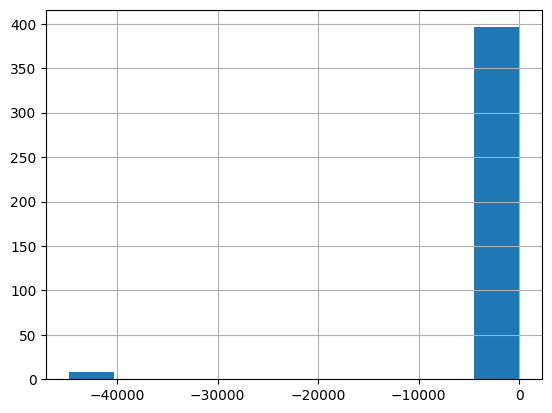

In [691]:
df['Tiempo_Sonda_Vesical'].hist()

In [692]:
# Los pacientes que tienen duraciones de cateter negativos no tienen fecha de retiro.
df.loc[df['Tiempo_Sonda_Vesical']<0, 'Tiempo_Sonda_Vesical'] = np.nan

<Axes: >

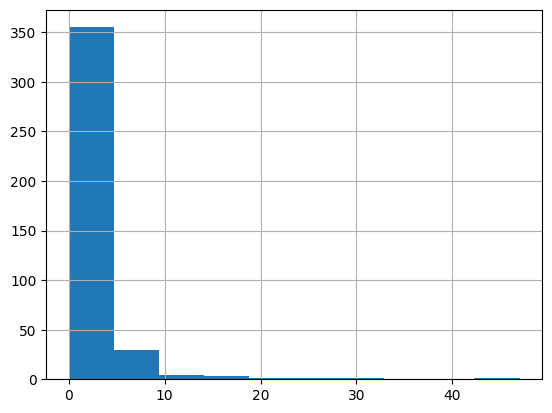

In [693]:
df['Tiempo_Sonda_Vesical'].hist()

In [694]:
ver_datos(df, 'Tiempo_Sonda_Vesical')

count    396.000000
mean       1.916667
std        3.965755
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       47.000000
Name: Tiempo_Sonda_Vesical, dtype: float64
--------------------
Número de datos nulos: 340


### Tiempo_CVC

In [695]:
ver_datos(df, 'Tiempo_CVC')

count      446.000000
mean     -3467.995516
std      11752.094236
min     -45245.000000
25%          2.000000
50%          6.000000
75%          9.000000
max        889.000000
Name: Tiempo_CVC, dtype: float64
--------------------
Número de datos nulos: 290


<Axes: >

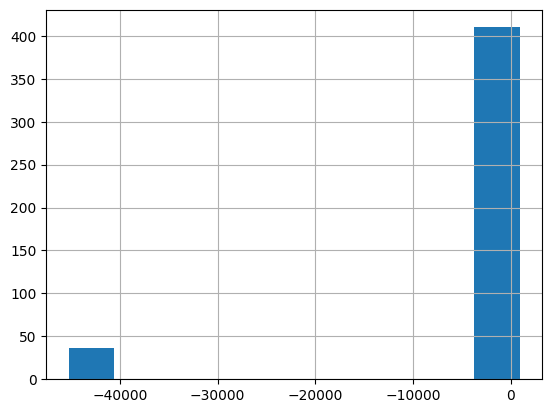

In [696]:
df['Tiempo_CVC'].hist()

In [697]:
# Los pacientes que tienen duraciones de cateter negativos no tienen fecha de retiro.
df.loc[df['Tiempo_CVC']<0, 'Tiempo_CVC'] = np.nan

<Axes: >

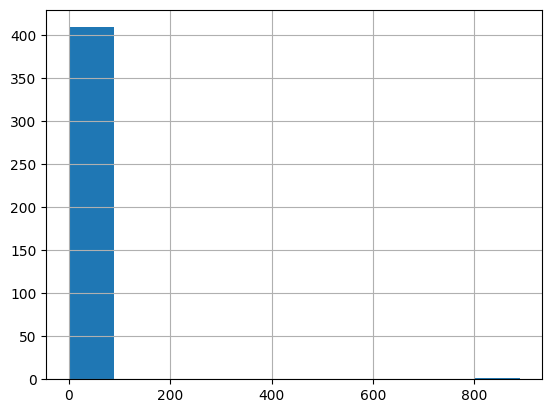

In [698]:
df['Tiempo_CVC'].hist()

In [699]:
# Vemos que la duración de 889 días es válida, pero corresponde a un valor atípico por lo que se omitirá
df[(df['Tiempo_CVC']>400)][['Fecha_Colocación_CVC','Fecha_Retiro_CVC','Tiempo_CVC']]

,Fecha_Colocación_CVC,Fecha_Retiro_CVC,Tiempo_CVC
#_Paciente,,,
440,2016-07-25 00:00:00,2018-12-31,889.0


In [700]:
df.loc[df['Tiempo_CVC']>800, 'Tiempo_CVC'] = np.nan

In [701]:
ver_datos(df, 'Tiempo_CVC')

count    409.000000
mean       7.422983
std        7.302938
min        0.000000
25%        4.000000
50%        6.000000
75%        9.000000
max       59.000000
Name: Tiempo_CVC, dtype: float64
--------------------
Número de datos nulos: 327


### Soporte_Vasopresor_PeriTx

In [702]:
ver_datos(df, 'Soporte_Vasopresor_PeriTx', True)

count    642.000000
mean       0.588785
std        0.492438
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Soporte_Vasopresor_PeriTx, dtype: float64
--------------------
Número de datos nulos: 94
--------------------
Soporte_Vasopresor_PeriTx
1.0    378
0.0    264
NaN     94
Name: count, dtype: int64


### Levosimendan_PeriTx

In [703]:
ver_datos(df, 'Levosimendan_PeriTx', True)

count    648.000000
mean       0.006173
std        0.078385
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Levosimendan_PeriTx, dtype: float64
--------------------
Número de datos nulos: 88
--------------------
Levosimendan_PeriTx
0.0    644
NaN     88
1.0      4
Name: count, dtype: int64


### Noradrenalina_PeriTx

In [704]:
ver_datos(df, 'Noradrenalina_PeriTx', True)

count    644.000000
mean       0.560559
std        0.496705
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Noradrenalina_PeriTx, dtype: float64
--------------------
Número de datos nulos: 92
--------------------
Noradrenalina_PeriTx
1.0    361
0.0    283
NaN     92
Name: count, dtype: int64


### Adrenalina_PeriTx

In [705]:
ver_datos(df, 'Adrenalina_PeriTx', True)

count    646.000000
mean       0.082043
std        0.274643
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Adrenalina_PeriTx, dtype: float64
--------------------
Número de datos nulos: 90
--------------------
Adrenalina_PeriTx
0.0    593
NaN     90
1.0     53
Name: count, dtype: int64


### Vasopresina_PeriTx

In [706]:
ver_datos(df, 'Vasopresina_PeriTx', True)

count    646.000000
mean       0.051084
std        0.220339
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Vasopresina_PeriTx, dtype: float64
--------------------
Número de datos nulos: 90
--------------------
Vasopresina_PeriTx
0.0    613
NaN     90
1.0     33
Name: count, dtype: int64


### Dopamina_PeriTx

In [707]:
ver_datos(df, 'Dopamina_PeriTx', True)

count    645.000000
mean       0.131783
std        0.338517
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Dopamina_PeriTx, dtype: float64
--------------------
Número de datos nulos: 91
--------------------
Dopamina_PeriTx
0.0    560
NaN     91
1.0     85
Name: count, dtype: int64


### Amiodarona_PeriTx

In [708]:
ver_datos(df, 'Amiodarona_PeriTx', True)

count    645.000000
mean       0.058915
std        0.441907
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       10.000000
Name: Amiodarona_PeriTx, dtype: float64
--------------------
Número de datos nulos: 91
--------------------
Amiodarona_PeriTx
0.0     616
NaN      91
1.0      28
10.0      1
Name: count, dtype: int64


In [709]:
df["Amiodarona_PeriTx"] = df["Amiodarona_PeriTx"].replace(10, 1)

In [710]:
ver_datos(df, 'Amiodarona_PeriTx', True)

count    645.000000
mean       0.044961
std        0.207380
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Amiodarona_PeriTx, dtype: float64
--------------------
Número de datos nulos: 91
--------------------
Amiodarona_PeriTx
0.0    616
NaN     91
1.0     29
Name: count, dtype: int64


### Stent

In [711]:
ver_datos(df, 'Stent', True)

count    651.000000
mean       0.168971
std        0.375014
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Stent, dtype: float64
--------------------
Número de datos nulos: 85
--------------------
Stent
0.0    541
1.0    110
NaN     85
Name: count, dtype: int64


### Requirió_Reconstrucción_Biliar

In [712]:
ver_datos(df, 'Requirió_Reconstrucción_Biliar', True)

count    652.000000
mean       0.044479
std        0.206314
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Requirió_Reconstrucción_Biliar, dtype: float64
--------------------
Número de datos nulos: 84
--------------------
Requirió_Reconstrucción_Biliar
0.0    623
NaN     84
1.0     29
Name: count, dtype: int64


### Profilaxis_Antitrombótica

In [713]:
ver_datos(df, 'Profilaxis_Antitrombótica', True)

count    533.000000
mean       0.969981
std        0.485736
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       11.000000
Name: Profilaxis_Antitrombótica, dtype: float64
--------------------
Número de datos nulos: 203
--------------------
Profilaxis_Antitrombótica
1.0     506
NaN     203
0.0      26
11.0      1
Name: count, dtype: int64


In [714]:
df["Profilaxis_Antitrombótica"] = df["Profilaxis_Antitrombótica"].replace(11, 1)

In [715]:
ver_datos(df, 'Profilaxis_Antitrombótica', True)

count    533.000000
mean       0.951220
std        0.215611
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Profilaxis_Antitrombótica, dtype: float64
--------------------
Número de datos nulos: 203
--------------------
Profilaxis_Antitrombótica
1.0    507
NaN    203
0.0     26
Name: count, dtype: int64


### Días_de_Profilaxis_Antitrombótica

In [716]:
ver_datos(df, 'Días_de_Profilaxis_Antitrombótica')

count    473.000000
mean       6.520085
std        8.788723
min        0.000000
25%        1.000000
50%        1.000000
75%        9.000000
max       54.000000
Name: Días_de_Profilaxis_Antitrombótica, dtype: float64
--------------------
Número de datos nulos: 263


### Fast_Track

In [717]:
ver_datos(df, 'Fast_Track', True)

count    696.000000
mean       0.089080
std        0.285065
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Fast_Track, dtype: float64
--------------------
Número de datos nulos: 40
--------------------
Fast_Track
0.0    634
1.0     62
NaN     40
Name: count, dtype: int64


### Días_En_UCI

In [718]:
ver_datos(df, 'Días_En_UCI')

count    697.000000
mean       4.568149
std        8.556524
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       94.000000
Name: Días_En_UCI, dtype: float64
--------------------
Número de datos nulos: 39


### Días_En_Hospitalización_Piso

In [719]:
ver_datos(df, 'Días_En_Hospitalización_Piso')

count      702.000000
mean      -377.676638
std       4167.865767
min     -45324.000000
25%          4.000000
50%          7.000000
75%         11.000000
max        125.000000
Name: Días_En_Hospitalización_Piso, dtype: float64
--------------------
Número de datos nulos: 34


In [720]:
df.loc[
    df["Días_En_Hospitalización_Piso"] < 0,
    "Días_En_Hospitalización_Piso"
] = np.nan

In [721]:
ver_datos(df, 'Días_En_Hospitalización_Piso')

count    696.000000
mean       9.022989
std        9.356999
min        0.000000
25%        4.000000
50%        7.000000
75%       11.000000
max      125.000000
Name: Días_En_Hospitalización_Piso, dtype: float64
--------------------
Número de datos nulos: 40


### Días_Totales_Intrahospitalarios

In [722]:
ver_datos(df, 'Días_Totales_Intrahospitalarios')

count      702.000000
mean      -373.457265
std       4168.268764
min     -45324.000000
25%          6.000000
50%          9.000000
75%         15.000000
max        184.000000
Name: Días_Totales_Intrahospitalarios, dtype: float64
--------------------
Número de datos nulos: 34


In [723]:
df.loc[
    df["Días_Totales_Intrahospitalarios"] < 0,
    "Días_Totales_Intrahospitalarios"
] = np.nan

In [724]:
ver_datos(df, 'Días_Totales_Intrahospitalarios')

count    696.000000
mean      13.278736
std       13.405460
min        0.000000
25%        6.000000
50%        9.000000
75%       15.000000
max      184.000000
Name: Días_Totales_Intrahospitalarios, dtype: float64
--------------------
Número de datos nulos: 40


### Fecha_Egreso_UCI


In [725]:
ver_datos(df, 'Fecha_Egreso_UCI')

count                     108
unique                    107
top       2017-11-09 00:00:00
freq                        2
Name: Fecha_Egreso_UCI, dtype: object
--------------------
Número de datos nulos: 628


In [726]:
df['Fecha_Egreso_UCI']=df['Fecha_Egreso_UCI'].apply(parse_date)

In [727]:
df.loc[df['Fecha_Egreso_UCI'] < '1900-01-01', 'Fecha_Egreso_UCI'] = pd.NaT

In [728]:
ver_datos(df, 'Fecha_Egreso_UCI')

count                              107
mean     2017-12-15 19:30:50.467289600
min                2004-08-14 00:00:00
25%                2014-07-21 12:00:00
50%                2017-02-11 00:00:00
75%                2023-02-15 00:00:00
max                2025-03-05 00:00:00
Name: Fecha_Egreso_UCI, dtype: object
--------------------
Número de datos nulos: 629


### Fecha_Egreso_Hospitalario

In [729]:
ver_datos(df, 'Fecha_Egreso_Hospitalario')

count                              155
mean     2019-11-18 15:38:19.354838784
min                2004-08-14 00:00:00
25%                2015-08-08 00:00:00
50%                2023-01-28 00:00:00
75%                2024-01-27 00:00:00
max                2025-03-13 00:00:00
Name: Fecha_Egreso_Hospitalario, dtype: object
--------------------
Número de datos nulos: 581


### ¿Complicación?

In [730]:
ver_datos(df, '¿Complicación?', True)

count     675
unique    162
top        NO
freq      259
Name: ¿Complicación?, dtype: object
--------------------
Número de datos nulos: 61
--------------------
¿Complicación?
NO                                 259
0                                   94
NaN                                 61
1                                   61
BILIAR                              19
                                  ... 
HERPES ZOSTER                        1
RECHAZO                              1
CHOQUE DISTRIBUTIVO                  1
FALLA RENAL                          1
DISFUNCIÓN PRIMARIA DEL INJERTO      1
Name: count, Length: 163, dtype: int64


In [731]:
df['¿Complicación?']=df['¿Complicación?'].replace(["NO", "N0", "NINGUNA", "NINGUNO", "NADA"], 0)
df.loc[df['¿Complicación?'].notna() & (df['¿Complicación?'] != 0), '¿Complicación?'] = 1

In [732]:
ver_datos(df, '¿Complicación?', True)

count     675
unique      2
top         0
freq      361
Name: ¿Complicación?, dtype: int64
--------------------
Número de datos nulos: 61
--------------------
¿Complicación?
0      361
1      314
NaN     61
Name: count, dtype: int64


### #_De_Complicaciones

In [733]:
ver_datos(df, '#_De_Complicaciones')

count    491.000000
mean       1.853360
std        3.887038
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       37.000000
Name: #_De_Complicaciones, dtype: float64
--------------------
Número de datos nulos: 245


### Tipo_De_Complicación_1

In [734]:
ver_datos(df, 'Tipo_De_Complicación_1', True)

count     537
unique     44
top         0
freq      256
Name: Tipo_De_Complicación_1, dtype: int64
--------------------
Número de datos nulos: 199
--------------------
Tipo_De_Complicación_1
0                                                                                       256
NaN                                                                                     199
1                                                                                        69
4                                                                                        34
15                                                                                       30
9                                                                                        22
3                                                                                        18
18                                                                                       15
5                                                                        

In [735]:
df['Tipo_De_Complicación_1'] = (
    df['Tipo_De_Complicación_1']
    .replace({
        "BUDD CHIARI AGUDO": 24,
        "STEVEN JOHNSON": 42,
        "FALLA RENAL AGUDA": 18,
        "FA, HEMOPERITONEO, FALLA RENAL, PARO RESPIRATORIO, STEVEN JOHNSON, FALLA RENAL AGUDA":18,
        "5,9,18":5,
        9.18:9,
        5.15:5,
        '7,15,18,33':7,
        4.18:4,
        '5,11,15,18,25,38':5
    })
)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\667141772.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({


In [736]:
ver_datos(df, 'Tipo_De_Complicación_1', True)

count    537.000000
mean       4.903166
std        8.251070
min        0.000000
25%        0.000000
50%        1.000000
75%        5.000000
max       41.000000
Name: Tipo_De_Complicación_1, dtype: float64
--------------------
Número de datos nulos: 199
--------------------
Tipo_De_Complicación_1
0.0     256
NaN     199
1.0      69
4.0      35
15.0     30
9.0      23
3.0      18
5.0      16
18.0     16
2.0      12
14.0      8
31.0      6
6.0       5
38.0      4
22.0      4
24.0      3
7.0       3
19.0      3
17.0      3
8.0       2
20.0      2
26.0      2
21.0      2
25.0      2
16.0      1
12.0      1
11.0      1
13.0      1
30.0      1
29.0      1
28.0      1
35.0      1
27.0      1
36.0      1
34.0      1
40.0      1
41.0      1
Name: count, dtype: int64


A partir de los datos de *Tipo de complicación* se ajustará la variable *¿Complicaciones?* para que sea coherente

In [737]:
df[["Tipo_De_Complicación_1","¿Complicación?"]].loc[(df["Tipo_De_Complicación_1"].notna())&(df["Tipo_De_Complicación_1"]!=0)&(df["¿Complicación?"]==0)]

,Tipo_De_Complicación_1,¿Complicación?
#_Paciente,,
289,4.0,0
304,2.0,0
586,9.0,0
590,15.0,0
595,15.0,0
596,15.0,0
597,15.0,0
600,9.0,0
603,5.0,0


In [738]:
df.loc[
    (df["Tipo_De_Complicación_1"].notna())
    &(df["Tipo_De_Complicación_1"]!=0)
    &(df["¿Complicación?"]==0), '¿Complicación?'] = 1

In [739]:
ver_datos(df, '¿Complicación?', True)

count     675
unique      2
top         0
freq      346
Name: ¿Complicación?, dtype: int64
--------------------
Número de datos nulos: 61
--------------------
¿Complicación?
0      346
1      329
NaN     61
Name: count, dtype: int64


### Inmunosupresión_con_Anticuerpos

In [740]:
ver_datos(df, 'Inmunosupresión_con_Anticuerpos', True)

count    228.000000
mean       0.250000
std        0.444001
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: Inmunosupresión_con_Anticuerpos, dtype: float64
--------------------
Número de datos nulos: 508
--------------------
Inmunosupresión_con_Anticuerpos
NaN    508
0.0    172
1.0     55
2.0      1
Name: count, dtype: int64


In [741]:
def clasificar_inmunosupresion(valor):
    if pd.isna(valor):
        return np.nan
    elif valor in [1, 2]:
        return "SI"
    else:
        return "NO"

df["Inmunosupresión_con_Anticuerpos"] = df["Inmunosupresión_con_Anticuerpos"].apply(clasificar_inmunosupresion)
selected_columns.append('Inmunosupresión_con_Anticuerpos')

In [742]:
ver_datos(df, 'Inmunosupresión_con_Anticuerpos', True)

count     228
unique      2
top        NO
freq      172
Name: Inmunosupresión_con_Anticuerpos, dtype: object
--------------------
Número de datos nulos: 508
--------------------
Inmunosupresión_con_Anticuerpos
NaN    508
NO     172
SI      56
Name: count, dtype: int64


### Rechazo_Agudo

In [743]:
ver_datos(df, 'Rechazo_Agudo', True)

count     672
unique      3
top         0
freq      537
Name: Rechazo_Agudo, dtype: int64
--------------------
Número de datos nulos: 64
--------------------
Rechazo_Agudo
0           537
1           134
NaN          64
MODERADO      1
Name: count, dtype: int64


In [744]:
df['Rechazo_Agudo']=df['Rechazo_Agudo'].replace('MODERADO', 1)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\4161090847.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Rechazo_Agudo']=df['Rechazo_Agudo'].replace('MODERADO', 1)


In [745]:
ver_datos(df, 'Rechazo_Agudo', True)

count    672.000000
mean       0.200893
std        0.400967
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Rechazo_Agudo, dtype: float64
--------------------
Número de datos nulos: 64
--------------------
Rechazo_Agudo
0.0    537
1.0    135
NaN     64
Name: count, dtype: int64


### Severidad_Rechazo_Agudo

In [746]:
ver_datos(df, 'Severidad_Rechazo_Agudo', True)

count     657
unique      6
top         0
freq      524
Name: Severidad_Rechazo_Agudo, dtype: int64
--------------------
Número de datos nulos: 79
--------------------
Severidad_Rechazo_Agudo
0      524
2       87
NaN     79
3       28
1       16
4        1
SI       1
Name: count, dtype: int64


In [747]:
df['Severidad_Rechazo_Agudo']=df['Severidad_Rechazo_Agudo'].replace('SI', 1)

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\1102723293.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Severidad_Rechazo_Agudo']=df['Severidad_Rechazo_Agudo'].replace('SI', 1)


In [748]:
ver_datos(df, 'Severidad_Rechazo_Agudo', True)

count    657.000000
mean       0.424658
std        0.885624
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: Severidad_Rechazo_Agudo, dtype: float64
--------------------
Número de datos nulos: 79
--------------------
Severidad_Rechazo_Agudo
0.0    524
2.0     87
NaN     79
3.0     28
1.0     17
4.0      1
Name: count, dtype: int64


### Rechazo_Crónico

In [749]:
ver_datos(df, 'Rechazo_Crónico', True)

count    671.000000
mean       0.005961
std        0.077036
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Rechazo_Crónico, dtype: float64
--------------------
Número de datos nulos: 65
--------------------
Rechazo_Crónico
0.0    667
NaN     65
1.0      4
Name: count, dtype: int64


### Infección_POP

In [750]:
ver_datos(df, 'Infección_POP', True)

count    562.000000
mean       0.268683
std        0.443670
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Infección_POP, dtype: float64
--------------------
Número de datos nulos: 174
--------------------
Infección_POP
0.0    411
NaN    174
1.0    151
Name: count, dtype: int64


### Tipo_Infección_1

In [751]:
ver_datos(df, 'Tipo_Infección_1', True)

count     254
unique     18
top         0
freq      103
Name: Tipo_Infección_1, dtype: int64
--------------------
Número de datos nulos: 482
--------------------
Tipo_Infección_1
NaN         482
0           103
2            50
10           22
1            17
3            13
8            10
5            10
11            8
6             5
4             4
16            2
18            2
BILIAR        2
7             2
13            1
17            1
9             1
NEUMONIA      1
Name: count, dtype: int64


In [752]:
df['Tipo_Infección_1']= df['Tipo_Infección_1'].replace({
    "BILIAR": "19",
    "NEUMONIA": "3",
})

In [753]:
ver_datos(df, 'Tipo_Infección_1', True)

count     254
unique     18
top         0
freq      103
Name: Tipo_Infección_1, dtype: int64
--------------------
Número de datos nulos: 482
--------------------
Tipo_Infección_1
NaN    482
0      103
2       50
10      22
1       17
3       13
8       10
5       10
11       8
6        5
4        4
16       2
18       2
19       2
7        2
13       1
17       1
9        1
3        1
Name: count, dtype: int64


### Germen_1

In [754]:
ver_datos(df, 'Germen_1', True)

count     198
unique     32
top         0
freq       85
Name: Germen_1, dtype: int64
--------------------
Número de datos nulos: 538
--------------------
Germen_1
NaN                                                                                       538
0                                                                                          85
1                                                                                          26
7                                                                                          23
17                                                                                          8
16                                                                                          6
14                                                                                          6
10                                                                                          5
2                                                                                    

In [755]:
df['Germen_1']= df['Germen_1'].replace({
    "KPC": 28,
    "e.coli": 7,
    "e.coliblee": 7,
    "ecoli blee":7,
    "candida":10,
    "CANDIDA":10,
    "S.CAPITIS": 19,
    "ECOLI": 7,
    "ENTEROBACTER CLOACAE, ENT\nEROCOCCUS FAECALIS, ESCHERICHI COLI Y CITROBACTER FREUNDII.":7
})

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\4156398199.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Germen_1']= df['Germen_1'].replace({


In [756]:
ver_datos(df, 'Germen_1', True)

count    198.000000
mean       5.707071
std        8.180393
min        0.000000
25%        0.000000
50%        1.000000
75%        7.000000
max       32.000000
Name: Germen_1, dtype: float64
--------------------
Número de datos nulos: 538
--------------------
Germen_1
NaN     538
0.0      85
7.0      27
1.0      26
17.0      8
10.0      6
14.0      6
16.0      6
2.0       5
3.0       4
28.0      3
32.0      2
26.0      2
12.0      2
19.0      2
6.0       2
24.0      2
23.0      2
4.0       1
8.0       1
22.0      1
18.0      1
30.0      1
27.0      1
9.0       1
31.0      1
Name: count, dtype: int64


### Fecha_Infección_1

In [757]:
ver_datos(df, 'Fecha_Infección_1')

count                     517
unique                    147
top       1927-05-17 00:00:00
freq                      280
Name: Fecha_Infección_1, dtype: object
--------------------
Número de datos nulos: 219


In [758]:
df['Fecha_Infección_1'] = df['Fecha_Infección_1'].apply(parse_date)

In [759]:
df['Fecha_Infección_1'] = df['Fecha_Infección_1'].replace(
    {
        pd.Timestamp('1927-05-17'): pd.NaT,
        pd.Timestamp('1902-09-25'): pd.NaT
    }
)

In [760]:
ver_datos(df, 'Fecha_Infección_1')

count                    145
mean     2014-12-29 14:24:00
min      2004-01-10 00:00:00
25%      2011-05-23 00:00:00
50%      2013-05-24 00:00:00
75%      2017-06-23 00:00:00
max      2024-05-18 00:00:00
Name: Fecha_Infección_1, dtype: object
--------------------
Número de datos nulos: 591


### Tiempo_Desde_Tx_Infección_1 (Fecha_Infección_1 - Fecha_Tx)

In [761]:
ver_datos(df, 'Tiempo_Desde_Tx_Infección_1', True)

count     634
unique    542
top        10
freq       11
Name: Tiempo_Desde_Tx_Infección_1, dtype: int64
--------------------
Número de datos nulos: 102
--------------------
Tiempo_Desde_Tx_Infección_1
NaN                    102
10                      11
7                        9
4                        8
9                        7
                      ... 
1777-02-16 00:00:00      1
1777-02-04 00:00:00      1
1777-01-20 00:00:00      1
121                      1
1824-07-03 00:00:00      1
Name: count, Length: 543, dtype: int64


Por como algunos datos están codificados como fechas se recalculará esta variable a partir de la fecha del transplante y la fecha de infección

In [762]:
df["Tiempo_Desde_Tx_Infección_1"] = (
    df["Fecha_Infección_1"] - df["Fecha_Tx"]
).dt.days

In [763]:
ver_datos(df, 'Tiempo_Desde_Tx_Infección_1', True)

count    145.000000
mean      22.393103
std       31.406010
min        0.000000
25%        7.000000
50%       12.000000
75%       24.000000
max      250.000000
Name: Tiempo_Desde_Tx_Infección_1, dtype: float64
--------------------
Número de datos nulos: 591
--------------------
Tiempo_Desde_Tx_Infección_1
NaN      591
10.0      11
7.0        9
9.0        9
4.0        8
8.0        7
6.0        7
15.0       6
14.0       6
1.0        5
24.0       4
5.0        4
12.0       4
18.0       4
21.0       3
11.0       3
3.0        3
16.0       3
22.0       3
17.0       3
19.0       2
78.0       2
37.0       2
0.0        2
23.0       2
26.0       2
42.0       2
2.0        2
28.0       1
35.0       1
111.0      1
250.0      1
64.0       1
102.0      1
55.0       1
58.0       1
31.0       1
20.0       1
13.0       1
36.0       1
25.0       1
38.0       1
48.0       1
70.0       1
43.0       1
52.0       1
29.0       1
74.0       1
41.0       1
44.0       1
173.0      1
121.0      1
34.0       1
57.0

### Falla_Cardiaca_POP

In [764]:
ver_datos(df, 'Falla_Cardiaca_POP', True)

count    623.000000
mean       0.020867
std        0.143053
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Falla_Cardiaca_POP, dtype: float64
--------------------
Número de datos nulos: 113
--------------------
Falla_Cardiaca_POP
0.0    610
NaN    113
1.0     13
Name: count, dtype: int64


### Arritmia_POP

In [765]:
ver_datos(df, 'Arritmia_POP', True)

count     626
unique     33
top         0
freq      544
Name: Arritmia_POP, dtype: int64
--------------------
Número de datos nulos: 110
--------------------
Arritmia_POP
0                                                                                                                                                                                                                                                               544
NaN                                                                                                                                                                                                                                                             110
1                                                                                                                                                                                                                                                                36
3                                                

In [766]:
# Supongamos que la columna se llama 'arritmia_pop'
df['Arritmia_pop_limpia'] = df['Arritmia_POP'].astype(str).str.upper().str.strip()

def clasificar_arritmia(texto):
    if texto in ['0', 'NO', 'N/A', 'NINGUNA']:
        return 0
    # Bradiarritmias
    elif any(x in texto for x in ['BRADI', 'ASISTOLIA', 'RITMO DE ESCAPE', 'AESP', 'PARO']):
        return 3
    # Taquiarritmias ventriculares
    elif any(x in texto for x in ['VENTRICULAR', 'FV', 'FIBRILACION VENTRICULAR', 'BIGEMINISMO']):
        return 2
    # Taquiarritmias supraventriculares
    elif any(x in texto for x in ['SUPRAVENT', 'FA ', 'FIBRILACION AURICULAR', 'TAQUICARDIA SINUSAL']):
        return 1
    # Casos dudosos o combinaciones múltiples
    elif any(c in texto for c in ['+', '/', 'Y']):
        # Si menciona taqui + bradi, podría marcarse como 1 (predomina taqui) o np.nan
        return np.nan
    else:
        return np.nan

df['arritmia_pop_cod'] = df['Arritmia_pop_limpia'].apply(clasificar_arritmia)

In [767]:
selected_columns.append('arritmia_pop_cod')

In [768]:
ver_datos(df, 'Arritmia_POP', True)

count     626
unique     33
top         0
freq      544
Name: Arritmia_POP, dtype: int64
--------------------
Número de datos nulos: 110
--------------------
Arritmia_POP
0                                                                                                                                                                                                                                                               544
NaN                                                                                                                                                                                                                                                             110
1                                                                                                                                                                                                                                                                36
3                                                

In [769]:
df["arritmia_pop_descripcion"] = (
    df["Arritmia_POP"]
    .map({0: "NO", 1: "TAQUIARRITMIA SUPRAVENTRICULAR", 2: "TAQUIARRITMIA VENTRICULAR", 3: "BRADIARRITMIA"})
    .fillna("NO")
)

In [770]:
selected_columns.append('arritmia_pop_descripcion')

In [771]:
ver_datos(df, 'arritmia_pop_descripcion', True)

count     736
unique      4
top        NO
freq      690
Name: arritmia_pop_descripcion, dtype: object
--------------------
Número de datos nulos: 0
--------------------
arritmia_pop_descripcion
NO                                690
TAQUIARRITMIA SUPRAVENTRICULAR     36
BRADIARRITMIA                       8
TAQUIARRITMIA VENTRICULAR           2
Name: count, dtype: int64


### Infarto_POP

In [772]:
ver_datos(df, 'Infarto_POP', True)

count     629
unique      5
top         0
freq      621
Name: Infarto_POP, dtype: int64
--------------------
Número de datos nulos: 107
--------------------
Infarto_POP
0                 621
NaN               107
1                   4
2                   2
P                   1
2 (2 INFARTOS)      1
Name: count, dtype: int64


In [773]:
def limpiar_infarto_pop(texto):
    if pd.isna(texto):
        return np.nan
    texto = str(texto).strip().upper()
    
    if texto in ['0','0.0', 'NO', 'N/A', 'NINGUNA']:
        return 0
    elif texto in ['1', '1.0','SI', 'SÍ']:
        return 1
    else:
        return np.nan

df['Infarto_POP'] = df['Infarto_POP'].apply(limpiar_infarto_pop)


In [774]:
ver_datos(df, 'Infarto_POP', True)

count    625.000000
mean       0.006400
std        0.079807
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Infarto_POP, dtype: float64
--------------------
Número de datos nulos: 111
--------------------
Infarto_POP
0.0    621
NaN    111
1.0      4
Name: count, dtype: int64


In [775]:
df["Infarto_POP_bool"] = df["Infarto_POP"].replace({0: False, 1: True})
ver_datos(df, 'Infarto_POP_bool', True)
selected_columns.append('Infarto_POP_bool')

count       625
unique        2
top       False
freq        621
Name: Infarto_POP_bool, dtype: object
--------------------
Número de datos nulos: 111
--------------------
Infarto_POP_bool
False    621
NaN      111
True       4
Name: count, dtype: int64


### EKG_VALOR_POP

In [776]:
ver_datos(df, 'EKG_VALOR_POP', True)

count     168
unique     35
top         0
freq      119
Name: EKG_VALOR_POP, dtype: int64
--------------------
Número de datos nulos: 568
--------------------
EKG_VALOR_POP
NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        568
0                                                                                                                                                           

In [777]:
def clasificar_ekg(valor):
    if pd.isna(valor) or valor.strip() in ['999', '']:
        return np.nan
    
    v = valor.upper()
    
    # Normal
    if any(x in v for x in ['0','NORMAL', 'RITMO SINUSAL', 'SIN CAMBIOS', 'SIN ALTERACIONES']):
        return 0
    
    # QTc prolongado
    elif 'QT' in v and any(x in v for x in ['1','PROLONG', 'QTC 5']):
        return 1
    
    # Trastornos de la repolarización
    elif any(x in v for x in ['2','REPOLAR', 'ONDA T', 'LESION', 'ISQUEM', 'ALTERACION INESPECIFICA']):
        return 2
    
    # Taquiarritmias supraventriculares
    elif any(x in v for x in ['3','TAQUICARDIA SINUSAL', 'TAQUIARDIA', 'FA ', 'FIBRILACION AURIC', 'FLUTTER', 'SUPRAVENTRICULAR']):
        return 3
    
    # Taquiarritmias ventriculares
    elif any(x in v for x in ['4','TAQUICARDIA VENTRICULAR', 'FIBRILACION VENTRICULAR']):
        return 4
    
    # Bradiarritmias
    elif any(x in v for x in ['5','BRADICARD', 'ASISTOL', 'BLOQUEO AV']):
        return 5
    
    # Extrasístoles
    elif 'EXTRASIST' in v or 'BIGEMINISMO' in v or '6' in v:
        return 6
    
    # Mala progresión de onda R
    elif 'ONDA R' in v or 'PROGRESION LENTA' in v or '7' in v:
        return 7
    
    # Bloqueo de rama derecha
    elif 'BLOQUEO DE RAMA DERECHA' in v or '8'in v:
        return 8
    
    # Bloqueo de rama izquierda
    elif 'BLOQUEO DE RAMA IZQ' in v or '9' in v:
        return 9
    
    else:
        return np.nan


# Aplicar
df['EKG_VALOR_POP_1'] = df['EKG_VALOR_POP'].astype(str).apply(clasificar_ekg)

# Ver resultado
ver_datos(df, 'EKG_VALOR_POP_1', True)

count    159.000000
mean       0.352201
std        1.038124
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: EKG_VALOR_POP_1, dtype: float64
--------------------
Número de datos nulos: 577
--------------------
EKG_VALOR_POP_1
NaN    577
0.0    141
3.0     13
2.0      3
5.0      1
6.0      1
Name: count, dtype: int64


In [778]:
selected_columns.append('EKG_VALOR_POP_1')

In [779]:
df["EKG_VALOR_POP_categoria"] = df["EKG_VALOR_POP_1"].replace({0: 'Normal', 1: 'QTc prolongado', 2: 'Trastornos de la repolarización', 
                                                                                             3: 'Taquiarritmias supraventriculares', 4: 'Taquiarritmias ventriculares', 
                                                                                             5: 'Bradiarritmias', 6: 'Extrasístoles', 7: 'Mala progresión de onda R',
                                                                                             8: 'Bloqueo de rama derecha', 9: 'Bloqueo de rama izquierda'})
selected_columns.append('EKG_VALOR_POP_categoria')
ver_datos(df, 'EKG_VALOR_POP_categoria', True)

count        159
unique         5
top       Normal
freq         141
Name: EKG_VALOR_POP_categoria, dtype: object
--------------------
Número de datos nulos: 577
--------------------
EKG_VALOR_POP_categoria
NaN                                  577
Normal                               141
Taquiarritmias supraventriculares     13
Trastornos de la repolarización        3
Bradiarritmias                         1
Extrasístoles                          1
Name: count, dtype: int64


### Ecocardiograma_POP_FE%

In [780]:
ver_datos(df, 'Ecocardiograma_POP_FE%')

count    126.000000
mean       7.888889
std       21.136593
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       85.000000
Name: Ecocardiograma_POP_FE%, dtype: float64
--------------------
Número de datos nulos: 610


### Ecocardiograma_POP_PASP

In [781]:
ver_datos(df, 'Ecocardiograma_POP_PASP', True)

count    123.000000
mean       3.040650
std       11.025602
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       72.000000
Name: Ecocardiograma_POP_PASP, dtype: float64
--------------------
Número de datos nulos: 613
--------------------
Ecocardiograma_POP_PASP
NaN     613
0.0     113
38.0      2
33.0      1
50.0      1
31.0      1
27.0      1
24.0      1
40.0      1
21.0      1
72.0      1
Name: count, dtype: int64


In [782]:
df['Ecocardiograma_POP_PASP'] = df['Ecocardiograma_POP_PASP'].replace(
    {
        0: np.nan
    }
)

In [783]:
ver_datos(df, 'Ecocardiograma_POP_PASP', True)

count    10.000000
mean     37.400000
std      14.833895
min      21.000000
25%      28.000000
50%      35.500000
75%      39.500000
max      72.000000
Name: Ecocardiograma_POP_PASP, dtype: float64
--------------------
Número de datos nulos: 726
--------------------
Ecocardiograma_POP_PASP
NaN     726
38.0      2
50.0      1
33.0      1
31.0      1
27.0      1
24.0      1
40.0      1
21.0      1
72.0      1
Name: count, dtype: int64


### Retrasplante

In [784]:
ver_datos(df,'Retrasplante', True)

count    732.000000
mean       0.060109
std        0.237852
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Retrasplante, dtype: float64
--------------------
Número de datos nulos: 4
--------------------
Retrasplante
0.0    688
1.0     44
NaN      4
Name: count, dtype: int64


In [785]:
df["Retrasplante_bool"] = df["Retrasplante"].replace({0: False, 1: True})
selected_columns.append("Retrasplante_bool")
ver_datos(df, "Retrasplante_bool")

count       732
unique        2
top       False
freq        688
Name: Retrasplante_bool, dtype: object
--------------------
Número de datos nulos: 4


### Indicación_Retrasplante

In [786]:
ver_datos(df, "Indicación_Retrasplante", True)

count    42.000000
mean      1.690476
std       1.219518
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       6.000000
Name: Indicación_Retrasplante, dtype: float64
--------------------
Número de datos nulos: 694
--------------------
Indicación_Retrasplante
NaN    694
1.0     26
2.0     11
5.0      2
3.0      1
4.0      1
6.0      1
Name: count, dtype: int64


In [787]:
df["Indicación_Retrasplante_categoria"] = df["Indicación_Retrasplante"].replace({1:'DISFUNCIÓN PRIMARIA DEL INJERTO', 2: 'TROMBOSIS ARTERIA HEPÁTICA', 3: 'TROMBOSIS PORTAL', 
                                                                                                     4: 'BUDD CHIARI', 5: 'COLANGIOPATIA ISQUEMICA', 6: 'HELLP'})
selected_columns.append('Indicación_Retrasplante_categoria')

In [788]:
ver_datos(df, "Indicación_Retrasplante_categoria", True)

count                                  42
unique                                  6
top       DISFUNCIÓN PRIMARIA DEL INJERTO
freq                                   26
Name: Indicación_Retrasplante_categoria, dtype: object
--------------------
Número de datos nulos: 694
--------------------
Indicación_Retrasplante_categoria
NaN                                694
DISFUNCIÓN PRIMARIA DEL INJERTO     26
TROMBOSIS ARTERIA HEPÁTICA          11
COLANGIOPATIA ISQUEMICA              2
TROMBOSIS PORTAL                     1
BUDD CHIARI                          1
HELLP                                1
Name: count, dtype: int64


### Año_Tx2 (si no retx, poner año tx)

In [789]:
ver_datos(df, "Año_Tx2 (si no retx, poner año tx)", True)

count     736.000000
mean     2013.767663
std         6.841577
min      1988.000000
25%      2009.000000
50%      2014.000000
75%      2019.000000
max      2025.000000
Name: Año_Tx2 (si no retx, poner año tx), dtype: float64
--------------------
Número de datos nulos: 0
--------------------
Año_Tx2 (si no retx, poner año tx)
2017    58
2009    45
2010    43
2016    43
2023    42
2015    40
2018    38
2024    37
2012    37
2008    34
2014    34
2011    33
2019    33
2022    30
2007    29
2013    27
2021    22
1998    19
2006    19
2004    14
2005    14
2020    13
2025     9
2003     8
2002     3
1991     2
1999     2
1994     2
1990     2
1989     2
1988     1
1997     1
Name: count, dtype: int64


In [790]:
df[["Fecha_Tx","Año_Tx2 (si no retx, poner año tx)","Fecha_Tx#2","Retrasplante","Indicación_Retrasplante_categoria"]].loc[df["Fecha_Tx#2"].notna() |
                                                                                                                        ((~df["Retrasplante"].astype(str).isin(["", "0.0", "NaN", "NAT", "NO"])) &  (df["Retrasplante"].notna())) |
                                                                                                                            df["Indicación_Retrasplante_categoria"].notnull() 
                                                                                                                            #| df["Año_Tx2 (si no retx, poner año tx)"].notna() # la variable tiene datos inconsistentes
                                                                                                                            ].head(5)

# # Convertir ambas columnas a datetime
# df_trans_hepatico["Fecha_Tx#2"] = pd.to_datetime(df_trans_hepatico["Fecha_Tx#2"], errors='coerce')

# df_trans_hepatico["Tiempo_Desde_Tx_Infección_1"] = (
#     df_trans_hepatico["Fecha_Infección_1"] - df_trans_hepatico["Fecha_Tx"]
# ).dt.days

# df_trans_hepatico["Tiempo_Desde_Tx_Infección_1"] = df_trans_hepatico["Tiempo_Desde_Tx_Infección_1"].astype("Int64")
# df_trans_hepatico["Tiempo_Desde_Tx_Infección_1"].unique()

,Fecha_Tx,"Año_Tx2 (si no retx, poner año tx)",Fecha_Tx#2,Retrasplante,Indicación_Retrasplante_categoria
#_Paciente,,,,,
35,2002-12-02,2006,2006-06-17,1.0,COLANGIOPATIA ISQUEMICA
52,2004-06-29,2004,2004-07-25,1.0,TROMBOSIS ARTERIA HEPÁTICA
69,2005-10-16,2005,2005-11-02,1.0,DISFUNCIÓN PRIMARIA DEL INJERTO
81,2006-07-11,2006,2006-12-06,1.0,COLANGIOPATIA ISQUEMICA
153,2008-12-26,2009,2009-01-08,1.0,DISFUNCIÓN PRIMARIA DEL INJERTO


Dado que el atributo Año_tx2 no es consistente con la variable retrasplante o indicacion retrasplante, se pensaria en ajustarla, sin embargo, la definición de la variable para los stakeholder sugiere que debe dejarse asi. 

Por lo tanto, se hará uso de las variables que presentan consistencia las cuales son Retrasplante, Indicacion_Retrasplante y Fecha_Tx#2. 

### Fecha_Tx#2

In [791]:
ver_datos(df, 'Fecha_Tx#2')
selected_columns.append('Fecha_Tx#2')

count                               44
mean     2014-11-06 09:49:05.454545408
min                2004-07-25 00:00:00
25%                2010-03-03 18:00:00
50%                2014-12-13 00:00:00
75%                2018-10-07 12:00:00
max                2025-03-04 00:00:00
Name: Fecha_Tx#2, dtype: object
--------------------
Número de datos nulos: 692


### Días_Desde_Tx#1(se puede hacer un calculo con años o algo así, como una nueva variable)

In [792]:
ver_datos(df, 'Días_Desde_Tx#1')

count      42.000000
mean       45.261905
std       199.944146
min         0.000000
25%         2.000000
50%         3.000000
75%        12.500000
max      1293.000000
Name: Días_Desde_Tx#1, dtype: float64
--------------------
Número de datos nulos: 694


In [793]:
# Ahora sí puedes restar fechas
df["Días_Desde_Tx#1_calculada"] = (
    df["Fecha_Tx#2"] - df["Fecha_Tx"]
).dt.days

df["Días_Desde_Tx#1_calculada"].describe()

count      44.000000
mean      123.477273
std       560.630438
min         0.000000
25%         2.000000
50%         3.000000
75%        14.000000
max      3530.000000
Name: Días_Desde_Tx#1_calculada, dtype: float64

In [794]:
df.loc[(df['Días_Desde_Tx#1']!=df['Días_Desde_Tx#1_calculada']) & df['Días_Desde_Tx#1_calculada'].notna()][['Días_Desde_Tx#1', 'Días_Desde_Tx#1_calculada', 'Fecha_Tx', 'Fecha_Tx#2']]

,Días_Desde_Tx#1,Días_Desde_Tx#1_calculada,Fecha_Tx,Fecha_Tx#2
#_Paciente,,,,
364,NaN,3530.0,2014-10-06,2024-06-05
712,NaN,2.0,2024-07-17,2024-07-19


In [795]:
df['Días_Desde_Tx#1'] = df['Días_Desde_Tx#1_calculada']

### Re_Re trasplante

In [796]:
ver_datos(df, 'Re_Re trasplante', True)

count    731.000000
mean       0.002736
std        0.052271
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Re_Re trasplante, dtype: float64
--------------------
Número de datos nulos: 5
--------------------
Re_Re trasplante
0.0    729
NaN      5
1.0      2
Name: count, dtype: int64


In [797]:
df[["Fecha_Tx","Fecha_Tx#2","Días_Desde_Tx#1","Días_Desde_Tx#1_calculada","Re_Re trasplante"]].loc[df["Fecha_Tx#2"].notna() ]

,Fecha_Tx,Fecha_Tx#2,Días_Desde_Tx#1,Días_Desde_Tx#1_calculada,Re_Re trasplante
#_Paciente,,,,,
35,2002-12-02,2006-06-17,1293.0,1293.0,0.0
52,2004-06-29,2004-07-25,26.0,26.0,0.0
69,2005-10-16,2005-11-02,17.0,17.0,0.0
81,2006-07-11,2006-12-06,148.0,148.0,0.0
153,2008-12-26,2009-01-08,13.0,13.0,0.0
164,2009-03-30,2009-04-03,4.0,4.0,0.0
181,2009-08-13,2009-08-18,5.0,5.0,0.0
185,2009-09-18,2009-09-20,2.0,2.0,0.0
195,2009-11-25,2009-11-26,1.0,1.0,0.0


Dada la definición del stakeholder para esta variable en donde "Re_Re Trasplante" : DEFINE SI EL PACIENTE REQUIRIÓ RE-RETRASPLANTE TEMPRANO (< 1AÑO), se evidencia que tiene inconsistencias, por lo que se procede a calcularla en funcon de Dias_Desde_Tx#1_calculada.

In [798]:
# Convertir a float para que los nulos sean np.nan y se puedan evaluar
dias = df["Días_Desde_Tx#1"].astype(float)

# Aplicar la lógica con np.where
df["Re_Re trasplante"] = np.where(
    dias < 366,
    True,
    np.where(dias.isna(), np.nan, False)
)

In [799]:
ver_datos(df, 'Re_Re trasplante', True)

count    44.000000
mean      0.954545
std       0.210707
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: Re_Re trasplante, dtype: float64
--------------------
Número de datos nulos: 692
--------------------
Re_Re trasplante
NaN    692
1.0     42
0.0      2
Name: count, dtype: int64


### Indicación_Re_Re_trasplante

In [800]:
ver_datos(df, 'Indicación_Retrasplante', True)

count    42.000000
mean      1.690476
std       1.219518
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       6.000000
Name: Indicación_Retrasplante, dtype: float64
--------------------
Número de datos nulos: 694
--------------------
Indicación_Retrasplante
NaN    694
1.0     26
2.0     11
5.0      2
3.0      1
4.0      1
6.0      1
Name: count, dtype: int64


In [801]:
df["Indicación_Retrasplante_categoria"] = df["Indicación_Retrasplante"].replace({1:'DISFUNCIÓN PRIMARIA DEL INJERTO', 2: 'TROMBOSIS ARTERIA HEPÁTICA', 3: 'TROMBOSIS PORTAL', 
                                                                                                     4: 'BUDD CHIARI', 5: 'COLANGIOPATIA ISQUEMICA', 6: 'HELLP'})
selected_columns.append('Indicación_Retrasplante_categoria')
ver_datos(df, 'Indicación_Retrasplante_categoria', True)

count                                  42
unique                                  6
top       DISFUNCIÓN PRIMARIA DEL INJERTO
freq                                   26
Name: Indicación_Retrasplante_categoria, dtype: object
--------------------
Número de datos nulos: 694
--------------------
Indicación_Retrasplante_categoria
NaN                                694
DISFUNCIÓN PRIMARIA DEL INJERTO     26
TROMBOSIS ARTERIA HEPÁTICA          11
COLANGIOPATIA ISQUEMICA              2
TROMBOSIS PORTAL                     1
BUDD CHIARI                          1
HELLP                                1
Name: count, dtype: int64


### PTLD

In [802]:
ver_datos(df, 'PTLD', True)

count     646
unique      3
top         0
freq      624
Name: PTLD, dtype: int64
--------------------
Número de datos nulos: 90
--------------------
PTLD
0      624
NaN     90
1       21
         1
Name: count, dtype: int64


In [803]:
df['PTLD'] = df['PTLD'].apply(lambda x: np.nan if isinstance(x, str) and x.strip() == '' else x)

In [804]:
ver_datos(df, 'PTLD', True)

count    645.000000
mean       0.032558
std        0.177615
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: PTLD, dtype: float64
--------------------
Número de datos nulos: 91
--------------------
PTLD
0.0    624
NaN     91
1.0     21
Name: count, dtype: int64


### Tiempo_Tx_A_PTLD

In [805]:
ver_datos(df, 'Tiempo_Tx_A_PTLD', True)

count     148
unique      3
top         0
freq      146
Name: Tiempo_Tx_A_PTLD, dtype: int64
--------------------
Número de datos nulos: 588
--------------------
Tiempo_Tx_A_PTLD
NaN          588
0            146
RITUXIMAB      1
1              1
Name: count, dtype: int64


La variable deberia reflejar el tiempo en dias desde el transplante a la identificación de un PTLD. Parece tener un comportamiento booleano. <span style="color:red"> No es consistente </span>

### Neoplasia_PostTx

In [806]:
ver_datos(df,'Neoplasia_PostTx', True)

count    634.000000
mean       0.075710
std        0.530828
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        7.000000
Name: Neoplasia_PostTx, dtype: float64
--------------------
Número de datos nulos: 102
--------------------
Neoplasia_PostTx
0.0    612
NaN    102
1.0     14
2.0      2
5.0      2
7.0      1
3.0      1
6.0      1
4.0      1
Name: count, dtype: int64


In [807]:
df["Neoplasia_PostTx"] = df["Neoplasia_PostTx"].replace({0:'NO' ,1:'PTLD', 2: 'CA PIEL', 3: 'CA PULMON', 
                                                        4: 'CA UTERO', 5: 'SARCOMA DE KAPOSI', 6: 'CA RENAL',
                                                        7: 'CA SENO',8:'LEUCEMIAS', 9: 'CA COLON',10 : 'LINFOMA' ,11:'COLANGIOCA',12: 'CA PROSTATA' ,13:'CA CERVIX',14:'PSEUDOMIXOMA PERITONEAL'})

In [808]:
ver_datos(df,'Neoplasia_PostTx', True)

count     634
unique      8
top        NO
freq      612
Name: Neoplasia_PostTx, dtype: object
--------------------
Número de datos nulos: 102
--------------------
Neoplasia_PostTx
NO                   612
NaN                  102
PTLD                  14
CA PIEL                2
SARCOMA DE KAPOSI      2
CA SENO                1
CA PULMON              1
CA RENAL               1
CA UTERO               1
Name: count, dtype: int64


### Tiempo_Tx_A_Neoplasia_PostTx

In [809]:
ver_datos(df, 'Tiempo_Tx_A_Neoplasia_PostTx', True)

count    147.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Tiempo_Tx_A_Neoplasia_PostTx, dtype: float64
--------------------
Número de datos nulos: 589
--------------------
Tiempo_Tx_A_Neoplasia_PostTx
NaN    589
0.0    147
Name: count, dtype: int64


La varaible no tiene datos. A pesar de que el conteo de no nulidad mostraba un 20% de completitud

In [810]:
# selected_columns.remove('Tiempo_Tx_A_Neoplasia_PostTx')

### Grado_HCC


In [811]:
ver_datos(df, 'Grado_HCC', True)

count    99.000000
mean      2.484848
std       0.675574
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: Grado_HCC, dtype: float64
--------------------
Número de datos nulos: 637
--------------------
Grado_HCC
NaN    637
2.0     49
3.0     40
4.0      6
1.0      4
Name: count, dtype: int64


In [812]:
grado_map = {
    1: "Bien diferenciado",
    2: "Moderadamente diferenciado",
    3: "Poco diferenciado",
    4: "Indiferenciado"
}

df["Grado_HCC_desc"] = df["Grado_HCC"].map(grado_map)
selected_columns.append('Grado_HCC_desc')

In [813]:
ver_datos(df, 'Grado_HCC_desc', True)

count                             99
unique                             4
top       Moderadamente diferenciado
freq                              49
Name: Grado_HCC_desc, dtype: object
--------------------
Número de datos nulos: 637
--------------------
Grado_HCC_desc
NaN                           637
Moderadamente diferenciado     49
Poco diferenciado              40
Indiferenciado                  6
Bien diferenciado               4
Name: count, dtype: int64


### Estadio

In [814]:
ver_datos(df, 'Estadio', True)

count    99.000000
mean      1.565657
std       0.687522
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       4.000000
Name: Estadio, dtype: float64
--------------------
Número de datos nulos: 637
--------------------
Estadio
NaN    637
1.0     53
2.0     37
3.0      8
4.0      1
Name: count, dtype: int64


In [815]:
df["Estadio"] = df["Estadio"].replace({0:'NO' ,1:'ESTADIO 1', 2: 'ESTADIO 2', 3: 'ESTADIO 3',4: 'ESTADIO 4'})

In [816]:
ver_datos(df, 'Estadio', True)

count            99
unique            4
top       ESTADIO 1
freq             53
Name: Estadio, dtype: object
--------------------
Número de datos nulos: 637
--------------------
Estadio
NaN          637
ESTADIO 1     53
ESTADIO 2     37
ESTADIO 3      8
ESTADIO 4      1
Name: count, dtype: int64


### Sobrevida_PeriQx_30_días_POP

In [817]:
ver_datos(df, 'Sobrevida_PeriQx_30_días_POP', True)

count    702.000000
mean       0.920228
std        0.271133
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Sobrevida_PeriQx_30_días_POP, dtype: float64
--------------------
Número de datos nulos: 34
--------------------
Sobrevida_PeriQx_30_días_POP
1.0    646
0.0     56
NaN     34
Name: count, dtype: int64


### Vivo hoy (Actualizado enero 2022)

In [818]:
ver_datos(df, 'Vivo_Hoy', True)

count    702.000000
mean       0.646724
std        0.478328
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Vivo_Hoy, dtype: float64
--------------------
Número de datos nulos: 34
--------------------
Vivo_Hoy
1.0    454
0.0    248
NaN     34
Name: count, dtype: int64


### Fecha_Control/Muerte

In [819]:
ver_datos(df, 'Fecha_Control/Muerte')

count                              702
mean     2021-11-20 01:58:58.461538560
min                2002-11-29 00:00:00
25%                2020-11-14 00:00:00
50%                2024-12-31 00:00:00
75%                2024-12-31 00:00:00
max                2025-04-01 00:00:00
Name: Fecha_Control/Muerte, dtype: object
--------------------
Número de datos nulos: 34


### Sobrevida (escoger entre Sobrevida_Días, Sobrevida_Meses, Sobrevida_Años)

In [820]:
ver_datos(df, "Sobrevida_Días")

count      704.000000
mean      2317.992898
std       3788.853487
min     -45745.000000
25%        489.500000
50%       2347.000000
75%       4013.000000
max       8086.000000
Name: Sobrevida_Días, dtype: float64
--------------------
Número de datos nulos: 32


In [821]:
df["Sobrevida_Días_calculado"] = (
    df["Fecha_Control/Muerte"] - df["Fecha_Tx"]
).dt.days
selected_columns.append("Sobrevida_Días_calculado")
ver_datos(df, "Sobrevida_Días_calculado")

count     702.000000
mean     2521.511396
std      2114.754796
min         0.000000
25%       499.000000
50%      2350.500000
75%      4013.000000
max      8086.000000
Name: Sobrevida_Días_calculado, dtype: float64
--------------------
Número de datos nulos: 34


<span style="color:red">Se sugiere trabajar con el dato calculado dado que se encuentra una inconsistencia en el dato capturado </span>

### Causa_De_Muerte

In [822]:
ver_datos(df, "Causa_De_Muerte", True)

count     117
unique     40
top         2
freq       25
Name: Causa_De_Muerte, dtype: int64
--------------------
Número de datos nulos: 619
--------------------
Causa_De_Muerte
NaN                               619
2                                  25
12                                 15
18                                 10
1                                   8
FALLA MULTI                         5
13                                  4
4                                   4
5                                   3
16                                  3
11                                  3
8                                   3
6                                   2
17                                  2
SHOCK SEPTICO/DISFUNCION            2
24                                  2
hiporexia                           2
choque mixto                        1
7                                   1
NEUMONIA COVID                      1
asistolia                           1
19                       

In [823]:
def clasificar_causa_muerte(texto):
    if pd.isna(texto):
        return np.nan

    texto = str(texto).upper().strip()

    # Mapeo directo por número
    if texto.isdigit():
        num = int(texto)
        if num in range(1, 25):
            return num

    # Reglas por texto libre
    elif any(x in texto for x in ['FALLA MULTI', 'MULTIORGAN']):
        return 12  # FALLA MULTIORGÁNICA
    elif 'SEPSIS' in texto:
        return 2   # SEPSIS
    elif any(x in texto for x in ['EMBOL', 'TROMBOSIS']):
        return 3   # EMBOLIA PULMONAR
    elif 'RECHAZO' in texto:
        return 4   # RECHAZO CRÓNICO
    elif any(x in texto for x in ['AEREA', 'OBSTRUCCION']):
        return 5   # OBSTRUCCIÓN DE LA VÍA AÉREA
    elif 'BRONCOASP' in texto:
        return 6   # BRONCOASPIRACIÓN
    elif 'COLANGIO' in texto:
        return 7   # COLANGIOCARCINOMA
    elif any(x in texto for x in ['NEURO', 'ENCEFAL', 'CEREBR']):
        return 8   # NEUROLÓGICA
    elif 'SUBARACNO' in texto:
        return 9   # HEMORRAGIA SUBARACNOIDEA
    elif 'HERPES' in texto:
        return 10  # ENCEFALITIS HERPES
    elif any(x in texto for x in ['NEUMON', 'COVID']):
        return 11  # NEUMONÍA
    elif any(x in texto for x in ['DISFUNCION', 'DISFUNCIÓN', 'HEPAT']):
        return 18  # DISFUNCIÓN HEPÁTICA
    elif 'ANGIOSARCOMA' in texto:
        return 14  # ANGIOSARCOMA
    elif 'HCC' in texto:
        return 15  # HCC
    elif any(x in texto for x in ['SHOCK', 'CHOQUE']):
        return 16  # SHOCK HIPOVOLÉMICO
    elif 'ASPERG' in texto:
        return 17  # ASPERGILOSIS
    elif 'ISQUEMIA' in texto:
        return 19  # ISQUEMIA MESENTÉRICA
    elif 'EDEMA' in texto:
        return 20  # EDEMA PULMONAR
    elif 'VENTILATOR' in texto:
        return 21  # FALLA VENTILATORIA
    elif 'ILEO' in texto:
        return 22  # ÍLEO ADINÁMICO
    elif 'HCV' in texto:
        return 23  # RECURRENCIA HCV
    elif 'ONCOL' in texto:
        return 24  # ONCOLÓGICO
    elif any(x in texto for x in ['RENAL', 'HIPOREXIA']):
        return 12  # FALLA MULTIORGÁNICA (asociado)
    else:
        return np.nan


# Aplicación sobre tu DataFrame
df["Causa_De_Muerte_cod"] = df["Causa_De_Muerte"].apply(clasificar_causa_muerte)
ver_datos(df, "Causa_De_Muerte_cod", True)

count    113.000000
mean       9.477876
std        6.783774
min        1.000000
25%        2.000000
50%       12.000000
75%       15.000000
max       24.000000
Name: Causa_De_Muerte_cod, dtype: float64
--------------------
Número de datos nulos: 623
--------------------
Causa_De_Muerte_cod
NaN     623
2.0      28
12.0     24
18.0     12
1.0       8
16.0      6
11.0      4
4.0       4
8.0       4
13.0      4
5.0       3
24.0      2
3.0       2
6.0       2
17.0      2
21.0      2
7.0       1
15.0      1
19.0      1
20.0      1
22.0      1
23.0      1
Name: count, dtype: int64


In [824]:
catalogo = {
    1: "COAGULOPATÍA", 2: "SEPSIS", 3: "EMBOLIA PULMONAR", 4: "RECHAZO CRÓNICO", 
    5: "OBSTRUCCIÓN DE LA VÍA AÉREA", 6: "BRONCOASPIRACIÓN", 7: "COLANGIOCARCINOMA", 
    8: "NEUROLÓGICA", 9: "HEMORRAGIA SUBARACNOIDEA", 10: "ENCEFALITIS HERPES", 
    11: "NEUMONÍA", 12: "FALLA MULTIORGÁNICA", 13: "MUERTE IO", 14: "ANGIOSARCOMA", 
    15: "HCC", 16: "SHOCK HIPOVOLÉMICO", 17: "ASPERGILOSIS", 18: "DISFUNCIÓN HEPÁTICA", 
    19: "ISQUEMIA MESENTÉRICA", 20: "EDEMA PULMONAR", 21: "FALLA VENTILATORIA", 
    22: "ÍLEO ADINÁMICO", 23: "RECURRENCIA HCV", 24: "ONCOLÓGICO"
}

df['Causa_De_Muerte_categoria'] = df['Causa_De_Muerte_cod'].map(catalogo)
selected_columns.append('Causa_De_Muerte_categoria')

In [825]:
ver_datos(df, "Causa_De_Muerte_categoria", True)

count        113
unique        21
top       SEPSIS
freq          28
Name: Causa_De_Muerte_categoria, dtype: object
--------------------
Número de datos nulos: 623
--------------------
Causa_De_Muerte_categoria
NaN                            623
SEPSIS                          28
FALLA MULTIORGÁNICA             24
DISFUNCIÓN HEPÁTICA             12
COAGULOPATÍA                     8
SHOCK HIPOVOLÉMICO               6
NEUMONÍA                         4
RECHAZO CRÓNICO                  4
NEUROLÓGICA                      4
MUERTE IO                        4
OBSTRUCCIÓN DE LA VÍA AÉREA      3
ONCOLÓGICO                       2
EMBOLIA PULMONAR                 2
BRONCOASPIRACIÓN                 2
ASPERGILOSIS                     2
FALLA VENTILATORIA               2
COLANGIOCARCINOMA                1
HCC                              1
ISQUEMIA MESENTÉRICA             1
EDEMA PULMONAR                   1
ÍLEO ADINÁMICO                   1
RECURRENCIA HCV                  1
Name: count, dtype: 

### Complicación_Asociada

In [826]:
ver_datos(df, 'Complicación_Asociada', True)

count         143
unique         54
top       NINGUNA
freq           54
Name: Complicación_Asociada, dtype: object
--------------------
Número de datos nulos: 593
--------------------
Complicación_Asociada
NaN                                                                                                                                                                                                                                                                                                                                                                  593
NINGUNA                                                                                                                                                                                                                                                                                                                                                               54
4                                                                       

In [827]:
df["Complicación_Asociada"].replace(["NO", "N0", "NINGUNA", "NINGUNO", "NADA"], 0, inplace=True)

ver_datos(df, 'Complicación_Asociada', True)

count     143
unique     54
top         0
freq       54
Name: Complicación_Asociada, dtype: int64
--------------------
Número de datos nulos: 593
--------------------
Complicación_Asociada
NaN                                                                                                                                                                                                                                                                                                                                                                  593
0                                                                                                                                                                                                                                                                                                                                                                     54
4                                                                                        

C:\Users\jmriv\AppData\Local\Temp\ipykernel_22692\4038440533.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Complicación_Asociada"].replace(["NO", "N0", "NINGUNA", "NINGUNO", "NADA"], 0, inplace=True)


### Fecha-Enlistamiento

In [828]:
ver_datos(df, 'Fecha-Enlistamiento')

count                     699
unique                    562
top       2009-11-19 00:00:00
freq                        5
Name: Fecha-Enlistamiento, dtype: object
--------------------
Número de datos nulos: 37


In [829]:
df['Fecha-Enlistamiento'] = df['Fecha-Enlistamiento'].apply(parse_date)

In [830]:
ver_datos(df, 'Fecha-Enlistamiento')

count                              699
mean     2014-07-11 01:38:53.047210240
min                2002-07-29 00:00:00
25%                2009-11-19 00:00:00
50%                2014-09-26 00:00:00
75%                2018-07-18 12:00:00
max                2025-02-12 00:00:00
Name: Fecha-Enlistamiento, dtype: object
--------------------
Número de datos nulos: 37


### αFP_PreTx

In [831]:
ver_datos(df, 'αFP_PreTx')

count      194.000000
mean       214.379072
std       1334.154884
min          1.230000
25%          3.680000
50%          6.475000
75%         21.975000
max      15487.000000
Name: αFP_PreTx, dtype: float64
--------------------
Número de datos nulos: 542


### αFP_Al_Dx

In [832]:
ver_datos(df, 'αFP_Al_Dx')

count     245.000000
mean       59.458449
std       188.843439
min         0.900000
25%         3.400000
50%         6.000000
75%        15.370000
max      1924.000000
Name: αFP_Al_Dx, dtype: float64
--------------------
Número de datos nulos: 491


### Tiempo_Isquemia_Fría_Tx#1

In [833]:
ver_datos(df, 'Tiempo_Isquemia_Fría_Tx#1')

count    701.000000
mean       7.444559
std        2.356060
min        0.000000
25%        5.630000
50%        7.400000
75%        9.000000
max       16.000000
Name: Tiempo_Isquemia_Fría_Tx#1, dtype: float64
--------------------
Número de datos nulos: 35


### Días_Sobrevida_Injerto_#1

In [834]:
ver_datos(df, 'Días_Sobrevida_Injerto_#1')

count      704.000000
mean      2051.998580
std       3738.751428
min     -45745.000000
25%        315.000000
50%       1948.000000
75%       3668.500000
max       7720.000000
Name: Días_Sobrevida_Injerto_#1, dtype: float64
--------------------
Número de datos nulos: 32


Se recalcula la variable de manera que es *Fecha_Tx*-*Control_Injerto_#1*

In [835]:
ver_datos(df, 'Control_Injerto_#1')

count                              701
mean     2021-02-22 19:59:39.457917184
min                2002-11-29 00:00:00
25%                2020-05-15 00:00:00
50%                2023-12-31 00:00:00
75%                2023-12-31 00:00:00
max                2025-04-01 00:00:00
Name: Control_Injerto_#1, dtype: object
--------------------
Número de datos nulos: 35


In [836]:
df['Días_Sobrevida_Injerto_calculado'] = df.apply(
    lambda row: (row['Control_Injerto_#1'] - row['Fecha_Tx']).days
    if pd.notna(row['Control_Injerto_#1']) and pd.notna(row['Fecha_Tx'])
    else np.nan,
    axis=1
)

In [837]:
df.loc[(df['Días_Sobrevida_Injerto_calculado']!=df['Días_Sobrevida_Injerto_#1'])
       & df['Control_Injerto_#1'].notna()
       ][['Fecha_Tx','Control_Injerto_#1','Días_Sobrevida_Injerto_#1','Días_Sobrevida_Injerto_calculado']]

,Fecha_Tx,Control_Injerto_#1,Días_Sobrevida_Injerto_#1,Días_Sobrevida_Injerto_calculado
#_Paciente,,,,
687,2023-10-21,2023-12-11,37.0,51.0


In [838]:
df['Días_Sobrevida_Injerto_#1'] = df['Días_Sobrevida_Injerto_calculado']

In [839]:
ver_datos(df, 'Días_Sobrevida_Injerto_#1')

count     701.000000
mean     2256.560628
std      2050.901631
min         0.000000
25%       317.000000
50%      1985.000000
75%      3670.000000
max      7720.000000
Name: Días_Sobrevida_Injerto_#1, dtype: float64
--------------------
Número de datos nulos: 35


### Meses_Sobrevida_Injerto_#1

In [840]:
ver_datos(df, 'Meses_Sobrevida_Injerto_#1')

count     703.000000
mean       68.496302
std       124.687539
min     -1524.833333
25%        10.533333
50%        64.966667
75%       122.300000
max       257.333333
Name: Meses_Sobrevida_Injerto_#1, dtype: float64
--------------------
Número de datos nulos: 33


Para garantizar consistencia se usa la misma fórmula que usan en la fuente de los datos para recalcular los meses y los años

In [841]:
df['Meses_Sobrevida_Injerto_#1'] = df['Días_Sobrevida_Injerto_#1']/30
ver_datos(df, 'Meses_Sobrevida_Injerto_#1')

count    701.000000
mean      75.218688
std       68.363388
min        0.000000
25%       10.566667
50%       66.166667
75%      122.333333
max      257.333333
Name: Meses_Sobrevida_Injerto_#1, dtype: float64
--------------------
Número de datos nulos: 35


### Años_Sobrevida_Injerto_#1

In [842]:
ver_datos(df, 'Años_Sobrevida_Injerto_#1')

count    703.000000
mean       5.708025
std       10.390628
min     -127.069444
25%        0.877778
50%        5.413889
75%       10.191667
max       21.444444
Name: Años_Sobrevida_Injerto_#1, dtype: float64
--------------------
Número de datos nulos: 33


In [843]:
df['Años_Sobrevida_Injerto_#1'] = df['Meses_Sobrevida_Injerto_#1']/12
ver_datos(df, 'Años_Sobrevida_Injerto_#1')

count    701.000000
mean       6.268224
std        5.696949
min        0.000000
25%        0.880556
50%        5.513889
75%       10.194444
max       21.444444
Name: Años_Sobrevida_Injerto_#1, dtype: float64
--------------------
Número de datos nulos: 35


### Diámetro_Nódulo_Principal_(cm)_Al_Dx

In [844]:
ver_datos(df, 'Diámetro_Nódulo_Principal_(cm)_Al_Dx')

count    105.000000
mean       3.283143
std        1.759876
min        0.230000
25%        2.000000
50%        3.000000
75%        4.000000
max       11.000000
Name: Diámetro_Nódulo_Principal_(cm)_Al_Dx, dtype: float64
--------------------
Número de datos nulos: 631


### Ki67

In [845]:
ver_datos(df, 'Ki67')

count    81.000000
mean      3.283951
std       6.211350
min       0.000000
25%       0.000000
50%       1.000000
75%       5.000000
max      40.000000
Name: Ki67, dtype: float64
--------------------
Número de datos nulos: 655


### #_Nódulos_Al_Dx

In [846]:
ver_datos(df, '#_Nódulos_Al_Dx')

count    132.000000
mean       1.651515
std        1.703095
min        0.000000
25%        0.750000
50%        1.000000
75%        2.000000
max        7.000000
Name: #_Nódulos_Al_Dx, dtype: float64
--------------------
Número de datos nulos: 604


# Código de anonimización

In [847]:
ver_datos(df, 'Código de anonimización')

count          736
unique         736
top       TXHEP720
freq             1
Name: Código de anonimización, dtype: object
--------------------
Número de datos nulos: 0


In [848]:
selected_columns.append('Código de anonimización')

## Etapa 3: exportar datos limpios

Finalmente se seleccionarán las variables de interés

In [849]:
output = df[selected_columns]

In [850]:
output

,Año_Tx,Mes_Tx#1,Edad_Al_Tx,Tiempo_En_Lista_Días,Tiempo_En_Lista_Meses,Tiempo_En_Lista_Años,Sexo_Receptor,EPS,Causa_1_Tx_Hepático_,Causa_2_Tx_Hepático_,...,EKG_VALOR_POP_1,EKG_VALOR_POP_categoria,Retrasplante_bool,Indicación_Retrasplante_categoria,Fecha_Tx#2,Indicación_Retrasplante_categoria,Grado_HCC_desc,Sobrevida_Días_calculado,Causa_De_Muerte_categoria,Código de anonimización
#_Paciente,,,,,,,,,,,,,,,,,,,,,
1,1988,6,14.00,NaN,NaN,NaN,2,NaN,23.0,0.0,...,NaN,NaN,False,NaN,NaT,NaN,NaN,NaN,NaN,TXHEP001
2,1989,1,0.91,NaN,NaN,NaN,1,NaN,14.0,0.0,...,NaN,NaN,False,NaN,NaT,NaN,NaN,NaN,NaN,TXHEP002
3,1989,10,28.00,NaN,NaN,NaN,2,NaN,23.0,0.0,...,NaN,NaN,False,NaN,NaT,NaN,NaN,NaN,NaN,TXHEP003
4,1990,9,27.00,NaN,NaN,NaN,2,NaN,8.0,0.0,...,NaN,NaN,False,NaN,NaT,NaN,NaN,NaN,NaN,TXHEP004
5,1990,9,37.00,NaN,NaN,NaN,2,NaN,9.0,0.0,...,NaN,NaN,False,NaN,NaT,NaN,NaN,NaN,NaN,TXHEP005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2025,2,68.00,15.0,0.500000,0.041667,2,1.0,9.0,3.0,...,NaN,NaN,False,NaN,NaT,NaN,Poco diferenciado,26.0,NaN,TXHEP732
733,2025,3,56.00,205.0,6.833333,0.569444,2,33.0,3.0,0.0,...,NaN,NaN,False,NaN,NaT,NaN,NaN,27.0,NaN,TXHEP733
734,2025,3,43.00,45740.0,1524.666667,127.055556,1,1.0,NaN,NaN,...,NaN,NaN,False,NaN,NaT,NaN,NaN,NaN,NaN,TXHEP734


In [851]:
output.to_excel('C:\\Users\\jmriv\\OneDrive - Universidad de los andes\\Semestres uniandes\\2025-2\\Ciencia de datos aplicada\\Proyecto transplantes hepáticos Fundación Sanatfé\\Trasplante hepático consolidado limpio.xlsx')